In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

import seaborn as sns

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

import sklearn
from sklearn import metrics

import numpy as np
import scipy

import datetime as dt
from datetime import date

from collections import OrderedDict

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

In [2]:
#Daten aus CSV-Datei laden
df = pd.read_csv("data.csv", index_col=0, parse_dates=True)
df.index.freq = "D"

#Sonnenaufgang/Sonnenuntergang laden und Tagesstunden berechnen
df["tagesstunden"] = round((pd.to_timedelta(
    pd.to_datetime(df["sonnenuntergang"]).dt.strftime("%H:%M:%S")).dt.total_seconds() - 
    pd.to_timedelta(pd.to_datetime(df["sonnenaufgang"]).dt.strftime("%H:%M:%S")).dt.total_seconds()) / 3600, 1)

df = df.drop(["sonnenaufgang", "sonnenuntergang"], axis=1)

#Luftfeuchtigkeit laden
df_ = pd.read_csv("Datenbeschaffung/kalender.csv", index_col=0, parse_dates=True, usecols=[0,2])
df_ = df_.join(pd.read_csv("Datenbeschaffung/stuttgart.csv", index_col=0, parse_dates=True, usecols=[0,1], squeeze=True).rename("stuttgart"))
df_ = df_.join(pd.read_csv("Datenbeschaffung/freiburg.csv", index_col=0, parse_dates=True, usecols=[0,1], squeeze=True).rename("freiburg"))
df_ = df_.join(pd.read_csv("Datenbeschaffung/mannheim.csv", index_col=0, parse_dates=True, usecols=[0,1], squeeze=True).rename("mannheim"))
df_ = df_.join(pd.read_csv("Datenbeschaffung/ulm.csv", index_col=0, parse_dates=True, usecols=[0,1], squeeze=True).rename("ulm"))

#Durchschnitt berechnen
df["luftfeuchtigkeit"] = round(((df_["stuttgart"] + df_["freiburg"] + df_["mannheim"] + df_["ulm"]) / 4), 1)

#Temporär für Analysen verwendete Spalten erstellen
df["luftfeuchtigkeit_gerundet"] = round(df["luftfeuchtigkeit"],0)
df["luftfeuchtigkeit_gruppiert"] = 5 * round(df["luftfeuchtigkeit"]/5)

#Aufteilung in zwei DataFrames für weitere Analysen
df_arbeitstag = df[df["arbeitstag"] == 1]
df_arbeitsfreiertag = df[df["arbeitstag"] == 0]

print(df)
print()
print(df.describe().transpose())

            verbrauch     monat   wochentag  arbeitstag  temperatur  tagesstunden  luftfeuchtigkeit  luftfeuchtigkeit_gerundet  luftfeuchtigkeit_gruppiert
datum                                                                                                                                                     
2015-01-01     126197    Januar  Donnerstag           0        -2.5           8.4              96.0                       96.0                        95.0
2015-01-02     147085    Januar     Freitag           1        -0.0           8.4              91.8                       92.0                        90.0
2015-01-03     141426    Januar     Samstag           0         1.2           8.4              97.2                       97.0                        95.0
2015-01-04     132446    Januar     Sonntag           0        -0.2           8.4              94.8                       95.0                        95.0
2015-01-05     152611    Januar      Montag           1        -0.5   

# <font size="7">Datenanalyse</font>

<font size="5">Die relative Luftfeuchtigkeit folgt einer jährlichen Saisonalität, es gibt allerdings gelegentlich stärkere Abweichungen. Die Luftfeuchtigkeit ist generell in den kalten Monaten von Oktober bis März etwas höher als in den wärmeren Monaten. Wärmere Luft kann mehr Feuchtigkeit aufnehmen, wodurch die relative Luftfeuchtigkeit dann niedriger ist als bei kälterer Luft, wenn sich die gleiche Menge an Wasser darin befindet. Generell reicht die Luftfeuchtigkeit von etwa 60% im Sommer bis zu 95% im Winter.</font>

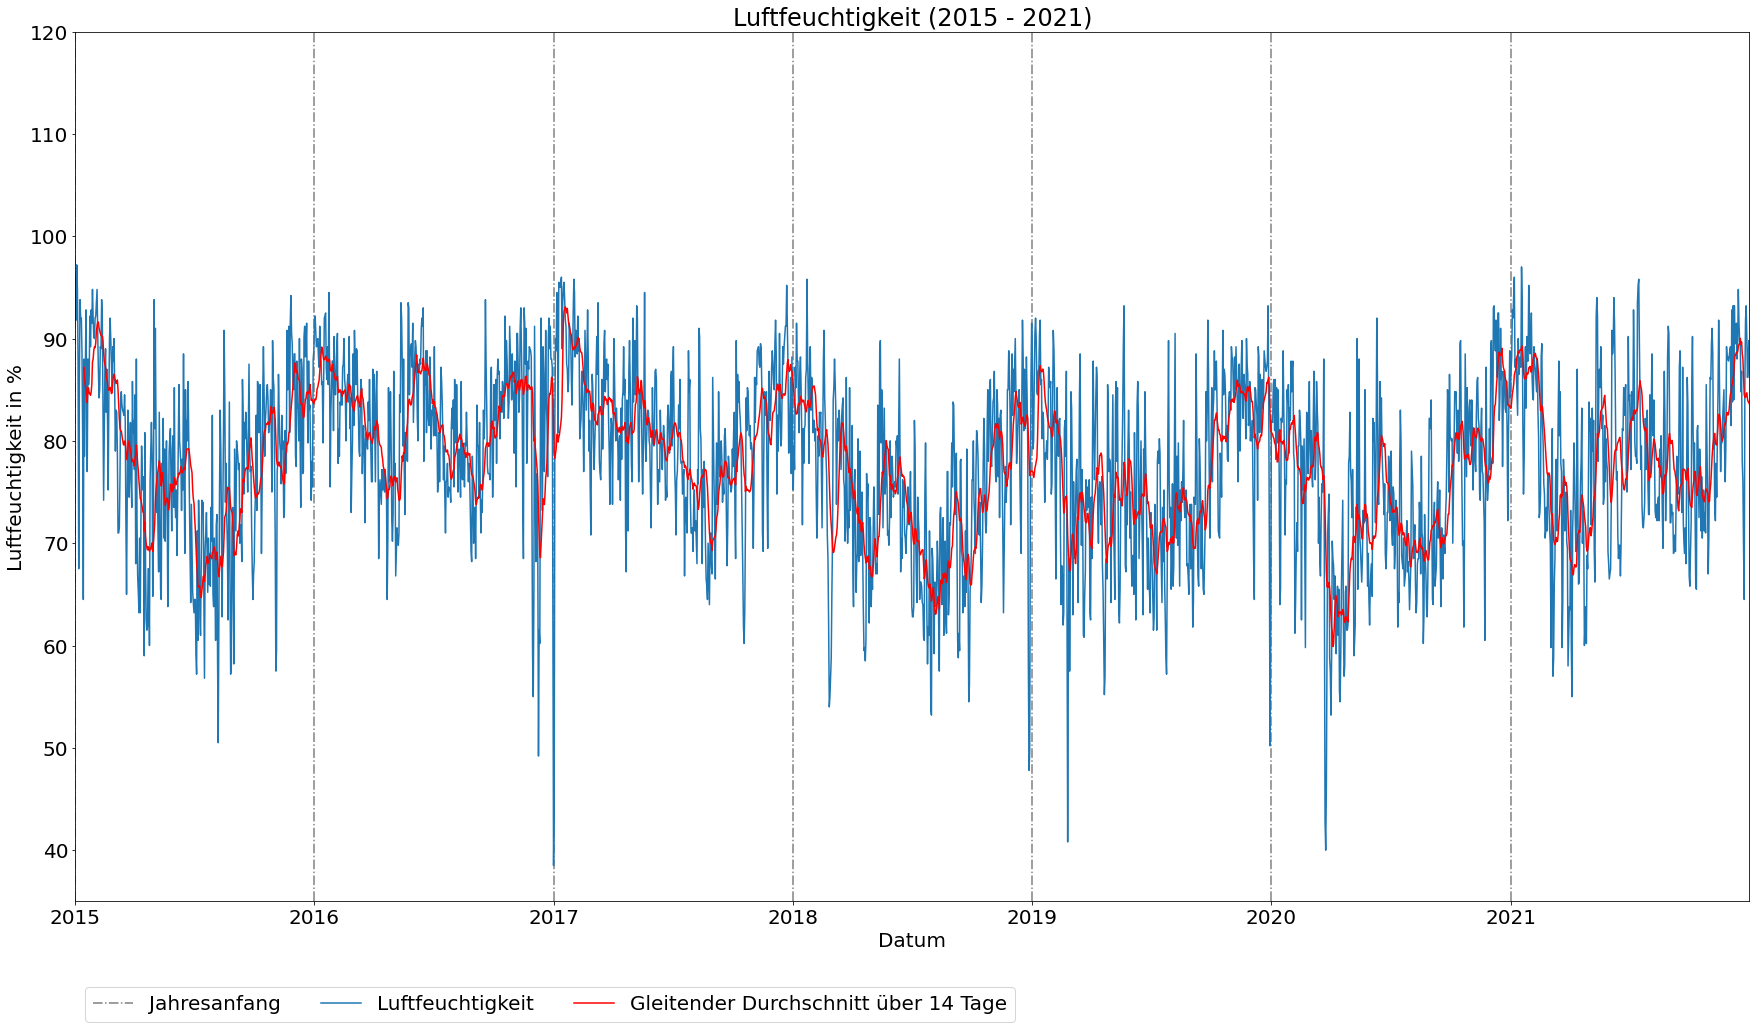

In [3]:
functions.draw_years(df)

#Luftfeuchtigkeit plotten
plt.plot(df["luftfeuchtigkeit"], label="Luftfeuchtigkeit");
plt.plot(df["luftfeuchtigkeit"].rolling(window=14).mean(), color="red", label="Gleitender Durchschnitt über 14 Tage")

#Achsen und Layout
plt.title("Luftfeuchtigkeit (2015 - 2021)")
plt.ylabel("Luftfeuchtigkeit in %")
plt.ylim(35, 120)
plt.xlabel("Datum")
plt.xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)

plt.show()

<font size="5">Diese jährliche Saisonalität zeigt sich auch bei der Betrachtung der Luftfeuchtigkeit nach Monaten. Hier zeigt sich auch der Zusammenhang mit der Temperatur sehr gut. Mitte des Jahres steigt die Luftfeuchtigkeit etwas an, da es in dieser Zeit häufiger regnet. Dies kann den Notebooks für die allgemeine Wetterbedingung und den Niederschlag ebenfalls entnommen werden.</font>

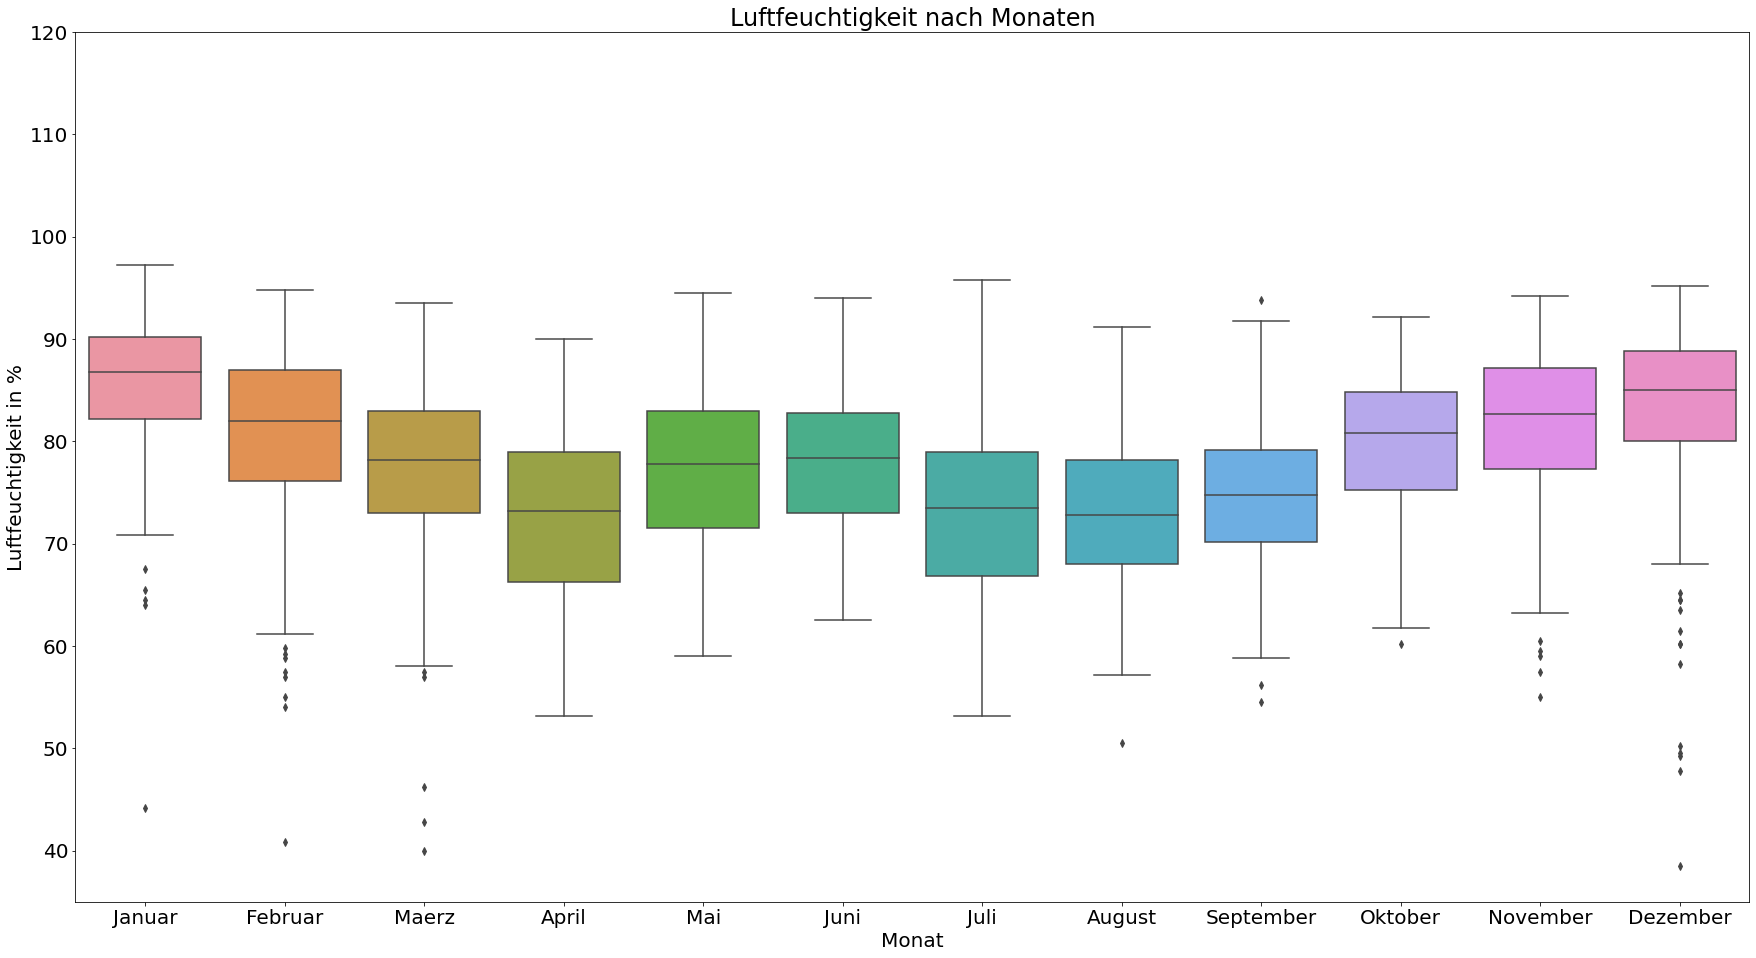

In [4]:
#Boxplot erstellen
sns.boxplot(data=df, x="monat", y="luftfeuchtigkeit")

#Achsen und Layout
plt.title("Luftfeuchtigkeit nach Monaten")
plt.ylabel("Luftfeuchtigkeit in %")
plt.ylim(35, 120)
plt.xlabel("Monat")

plt.show()

<font size="5">Die Werte des Merkmals sind linksschief um den Mittelwert verteilt.</font>

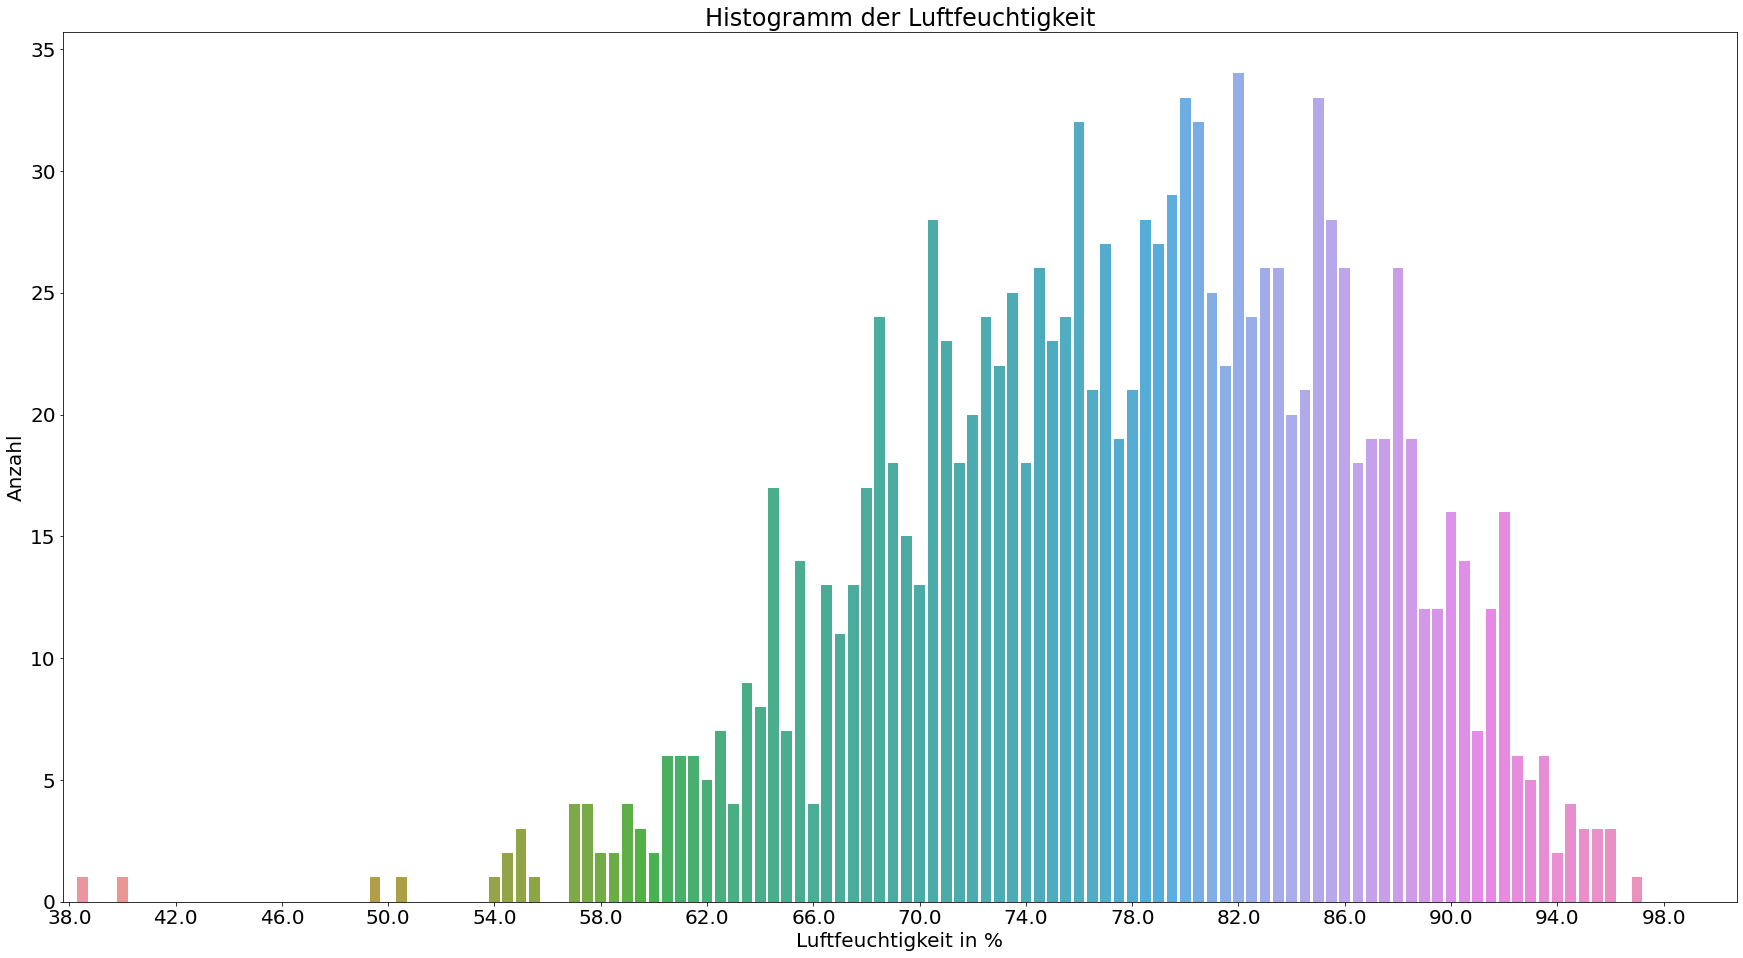

In [5]:
#Histogramm erstellen
sns.countplot(df["luftfeuchtigkeit"], order=np.arange(38, 101, 0.5))

#Achsen und Layout
plt.title("Histogramm der Luftfeuchtigkeit")
plt.ylabel("Anzahl")
plt.xlabel("Luftfeuchtigkeit in %")
plt.xticks(np.arange(0, 121, 8))

plt.show()

# <font size="7">Korrelationsanalyse</font>

## <font size="6">Liniendiagramm (Verlauf)</font><a class="anchor" id="2-04b-verlauf"></a>

<font size="5">Der Stromverbrauch und die Luftfeuchtigkeit verlaufen sehr ähnlich, da beide Merkmale ihr Maximum in den Wintermonaten Anfang bzw. Ende des Jahres erreichen und gegen Mitte des Jahres fallen. Meistens steigt die Luftfeuchtigkeit ähnlich wie der Stromverbrauch Mitte des Jahres wieder etwas an. Dies wird besonders bei Betrachtung der gleitenden Durchschnitte deutlich. Aufgrund der bereits beschriebenen Zusammenhänge der relativen Luftfeuchtigkeit und der Temperatur muss auch hier überprüft werden, ob es sich um eine Scheinkorrelation von Luftfeuchtigkeit und Stromverbrauch handelt.</font>

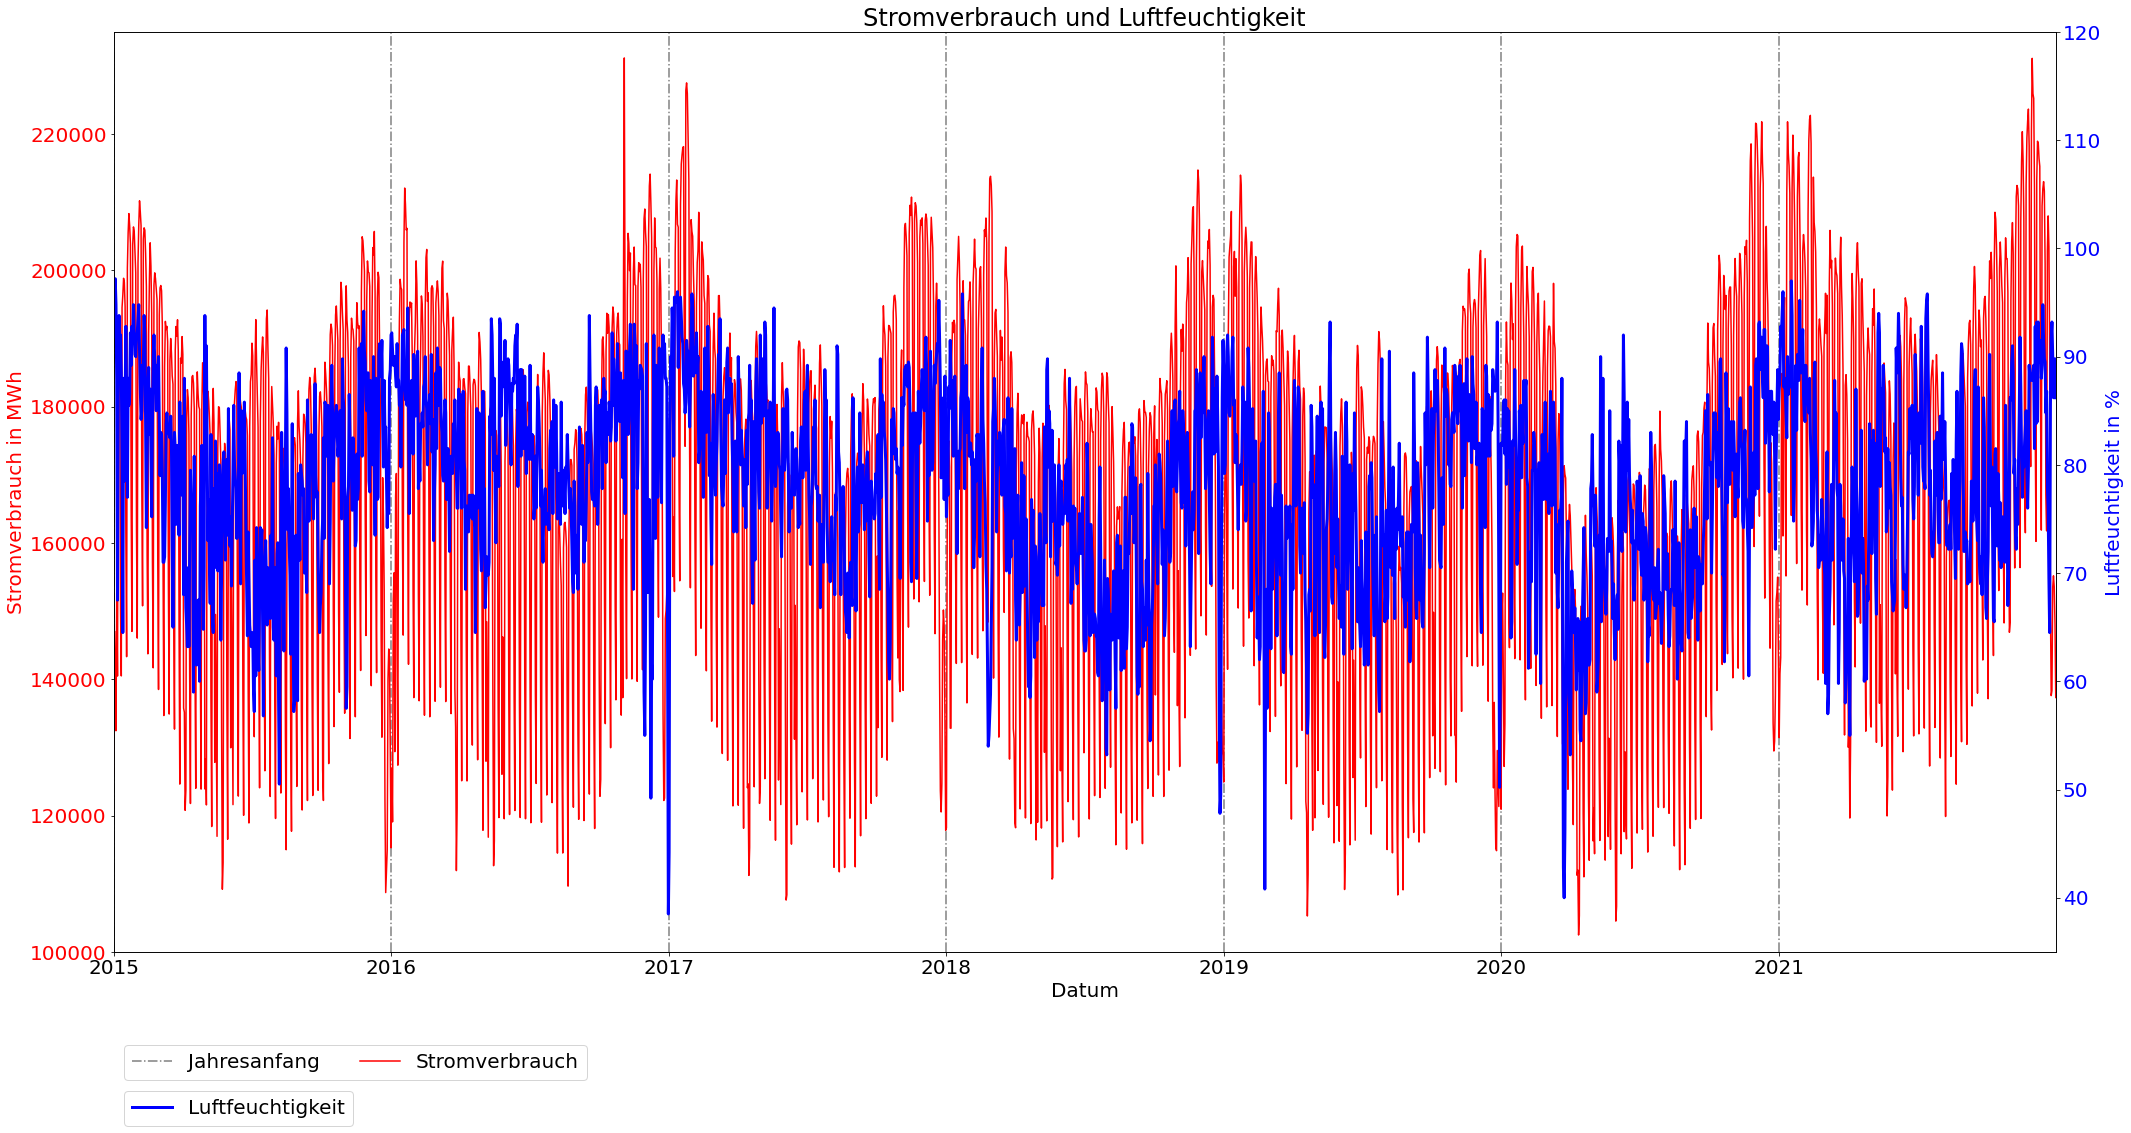

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.161
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.191
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.131





In [6]:
fig, ax1 = plt.subplots()

functions.draw_years(df)

ax1.set_title("Stromverbrauch und Luftfeuchtigkeit")

#Verbrauch plotten
ax1.plot(df["verbrauch"], color="red", label="Stromverbrauch")
#Achsen und Layout
ax1.set_ylabel("Stromverbrauch in MWh", color="red")
ax1.tick_params(axis="y", labelcolor="red")
ax1.set_ylim(100000,235000)
ax1.set_xlabel("Datum")
ax1.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)

ax2 = ax1.twinx()
#Luftfeuchtigkeit plotten
ax2.plot(df["luftfeuchtigkeit"], color="blue", linewidth=3, label="Luftfeuchtigkeit")
#Achsen und Layout
ax2.set_ylabel("Luftfeuchtigkeit in %", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.set_ylim(35, 120)
ax2.set_xlabel("Datum")
ax2.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.tight_layout()
plt.show()

#Korrelationskoeffizienten ausgeben
functions.correlation_coefficients(df["luftfeuchtigkeit"], df["verbrauch"])
print("\n\n")

<a class="anchor" id="2-04b-verlaufdurchschnitt"></a>



 Gleitender Durchschnitt über 3  Tage----------------------------------------------------------------------------------------------------------------------------------------------




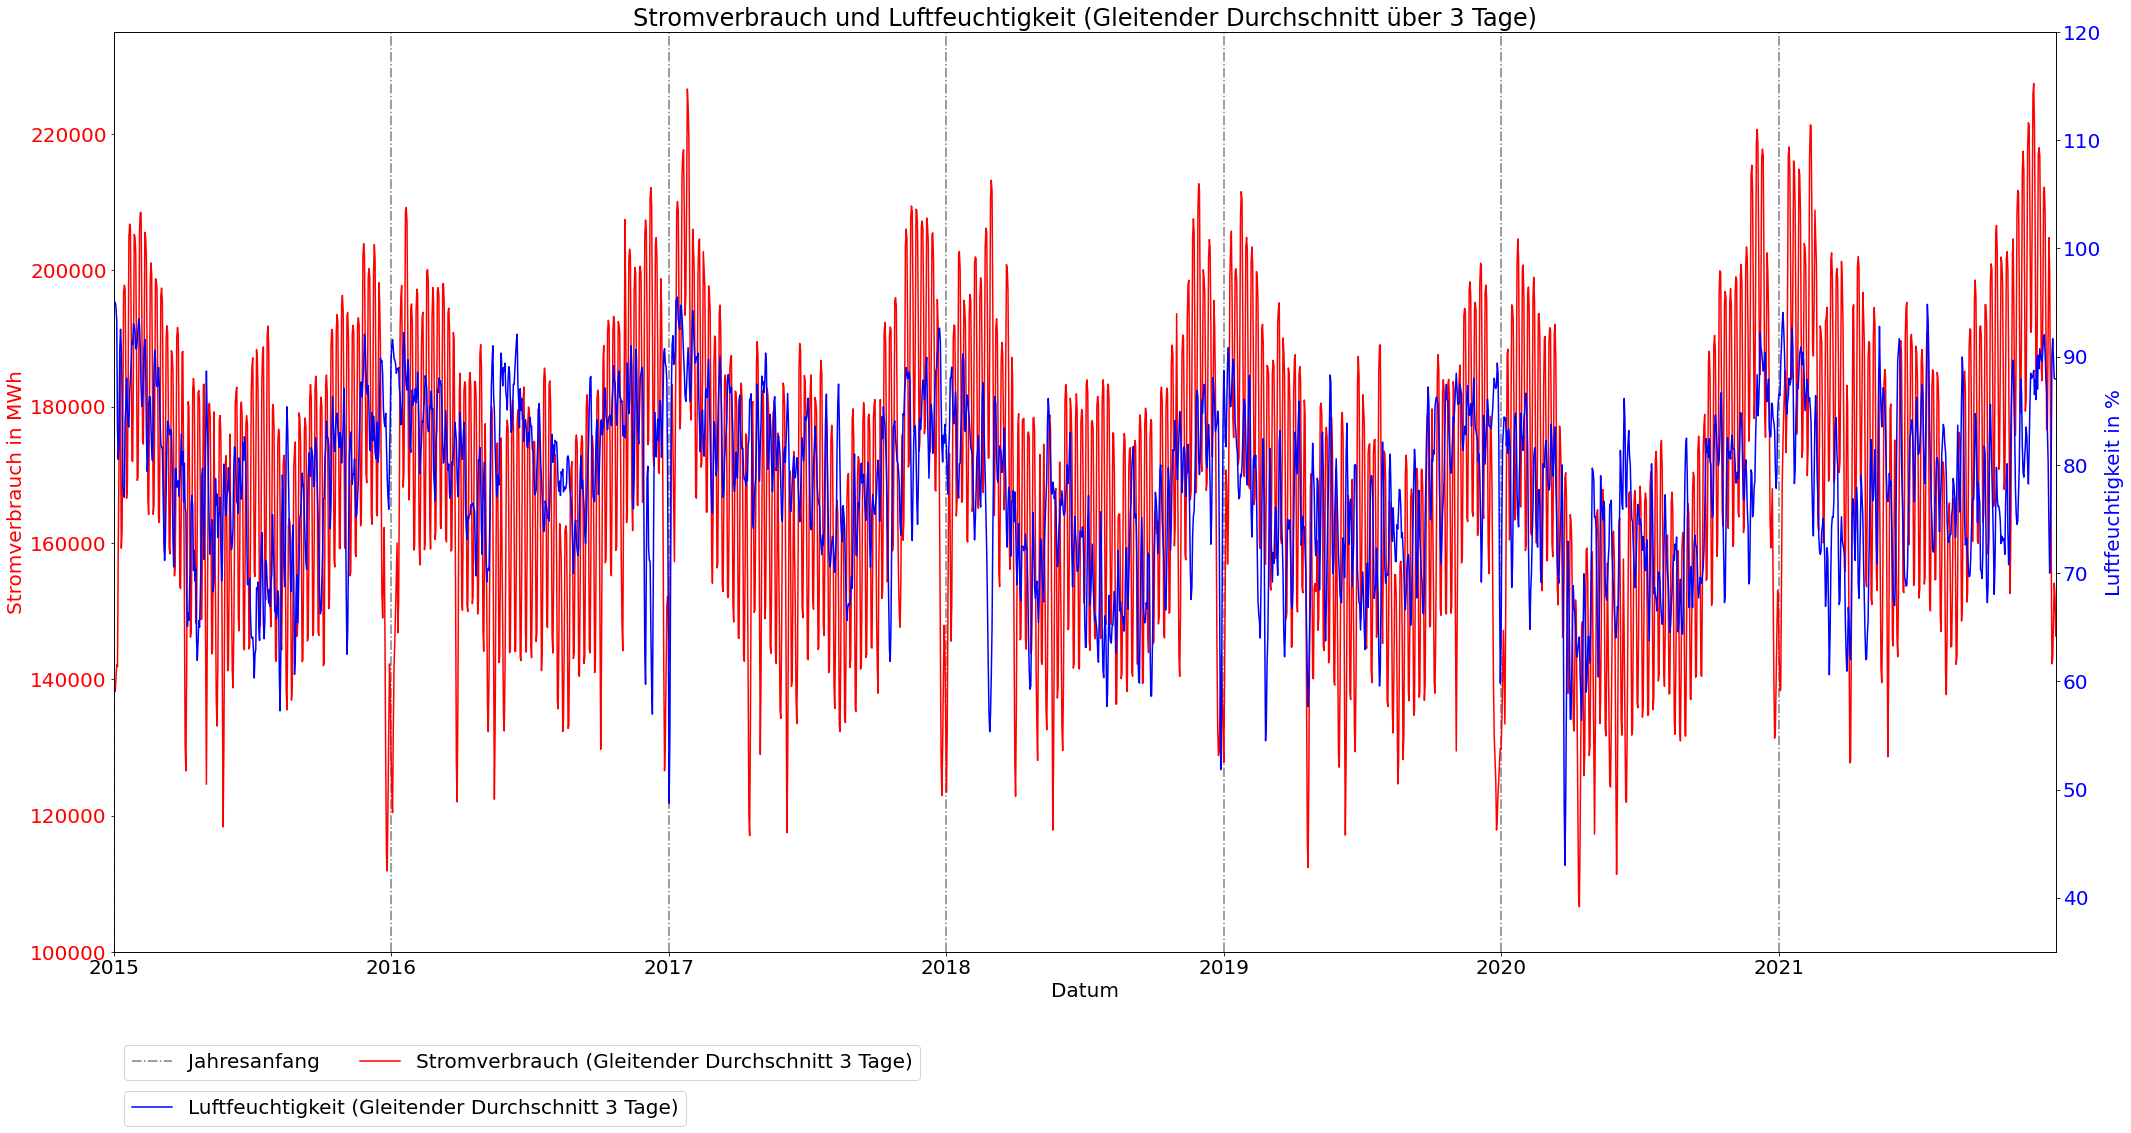

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.239
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.246
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.166





 Gleitender Durchschnitt über 7  Tage----------------------------------------------------------------------------------------------------------------------------------------------




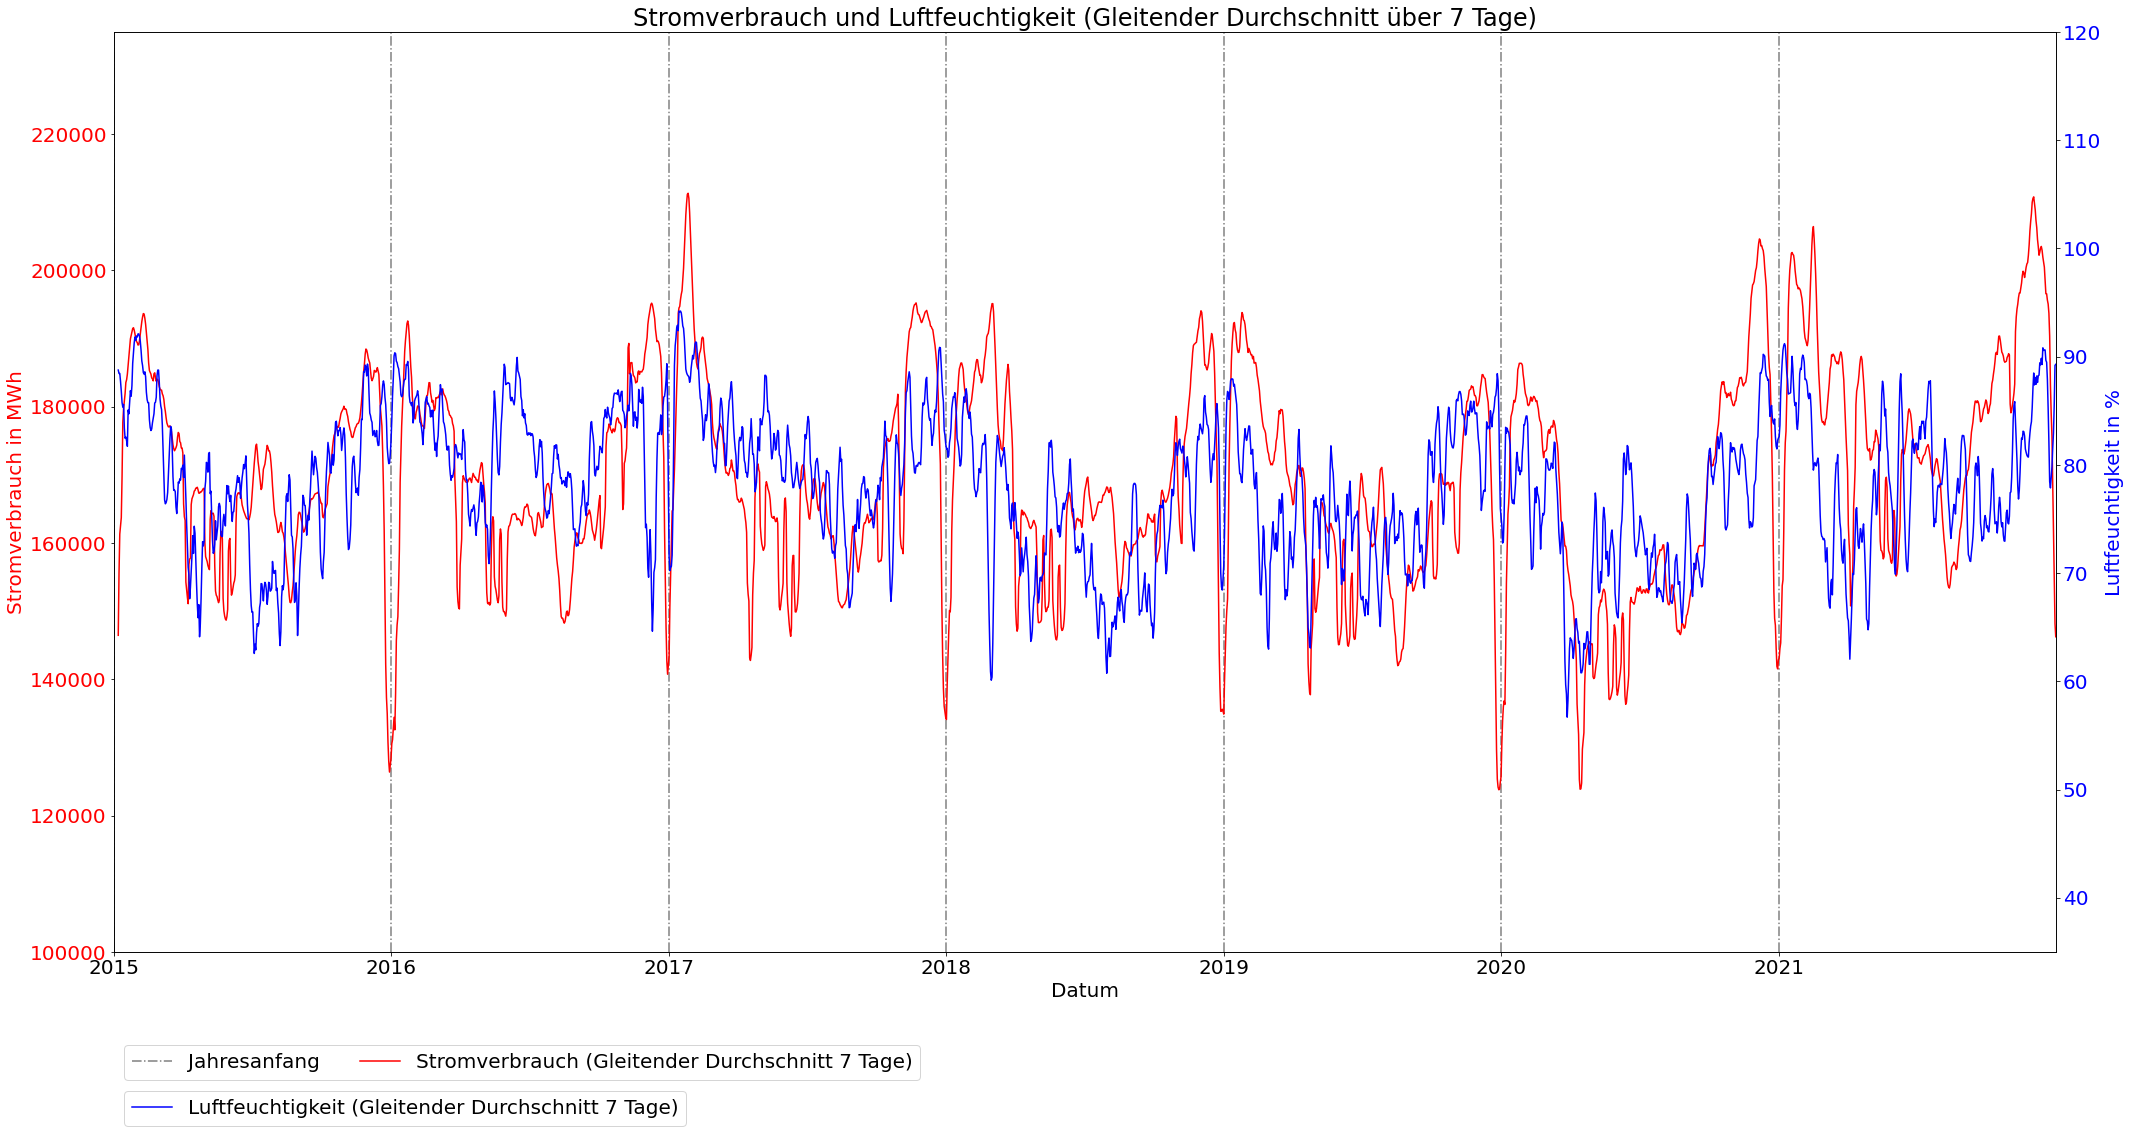

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.404
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.412
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.285





 Gleitender Durchschnitt über 14  Tage----------------------------------------------------------------------------------------------------------------------------------------------




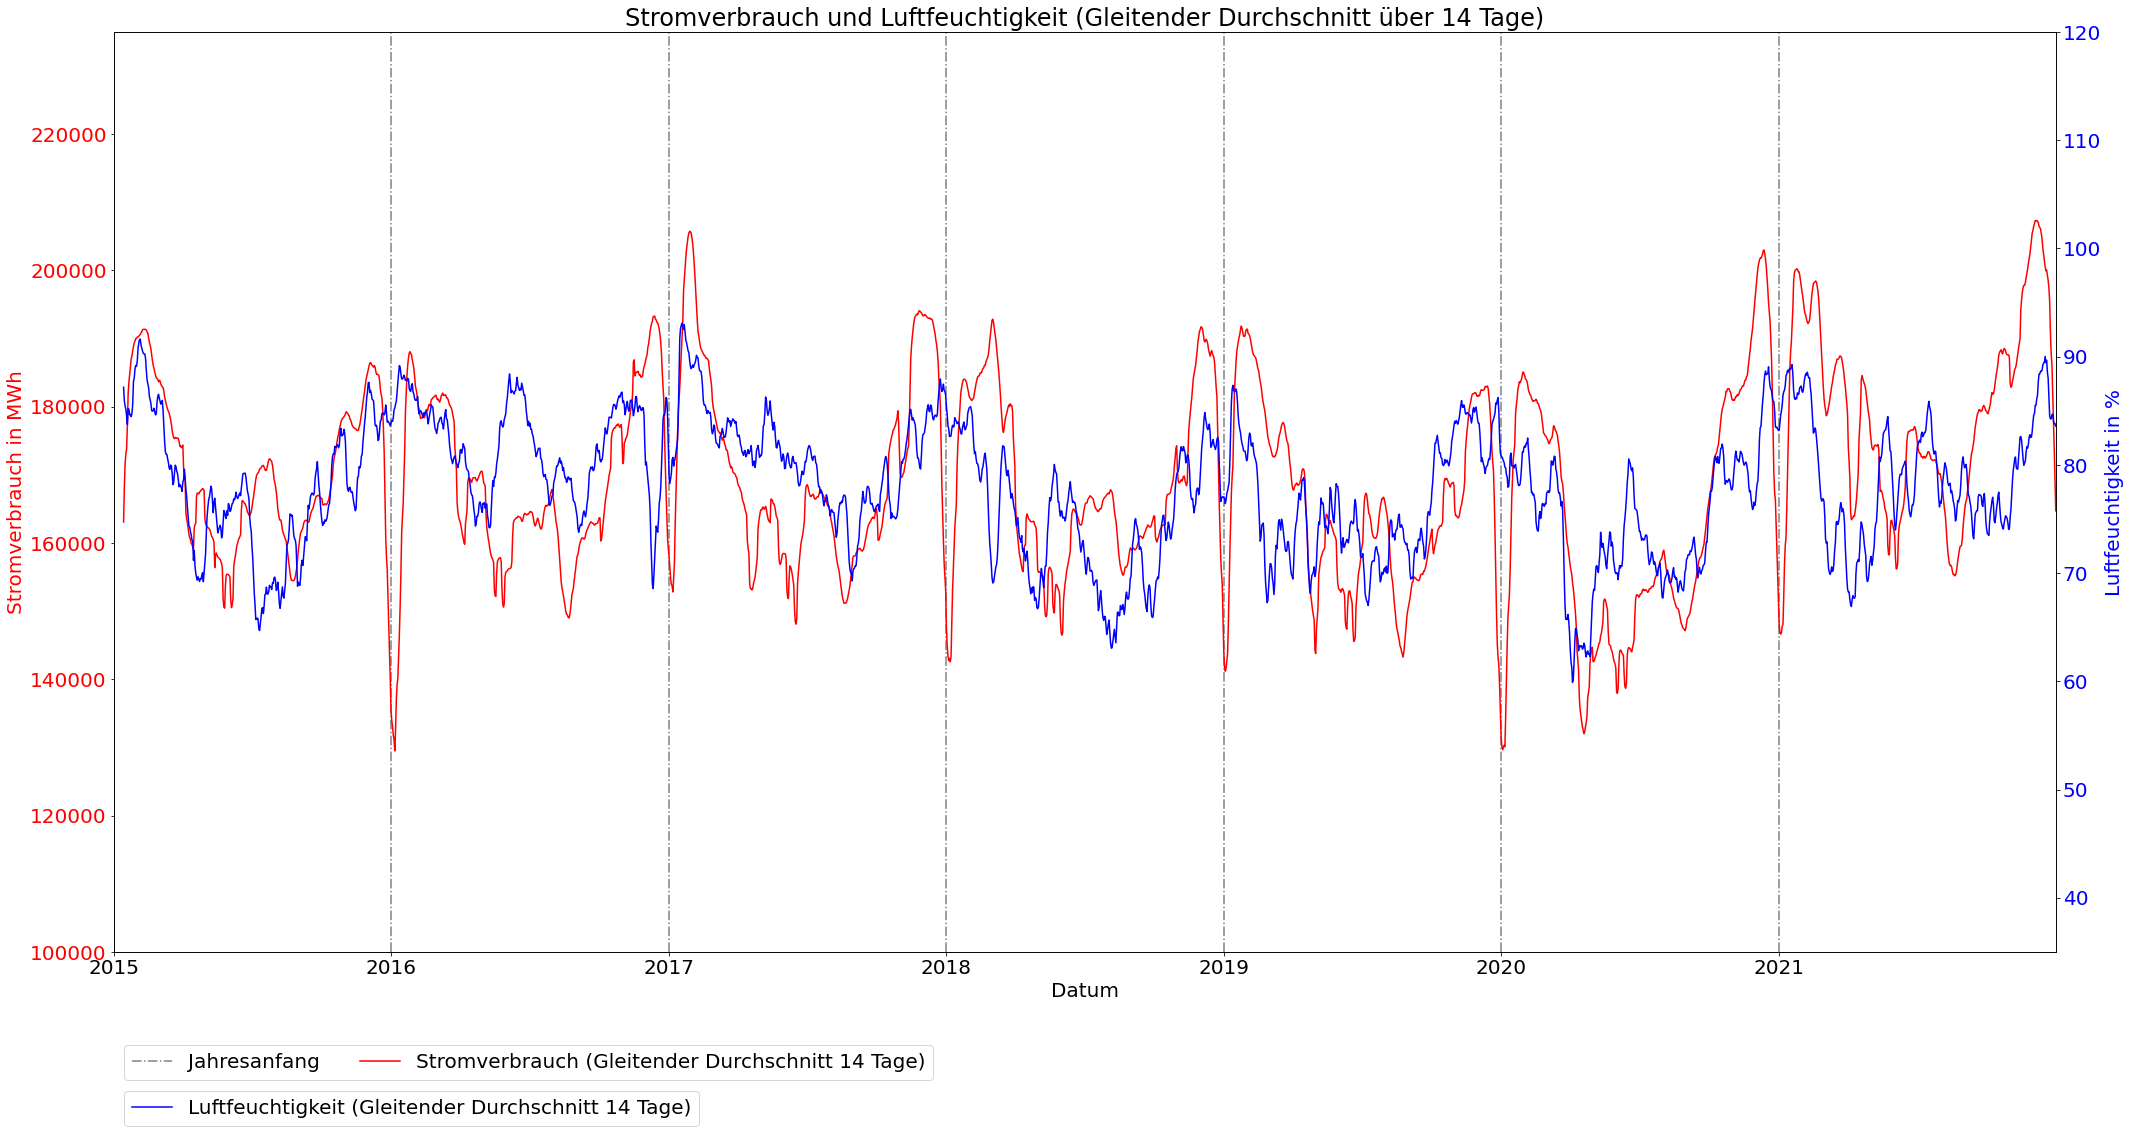

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.463
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.456
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.317





 Gleitender Durchschnitt über 28  Tage----------------------------------------------------------------------------------------------------------------------------------------------




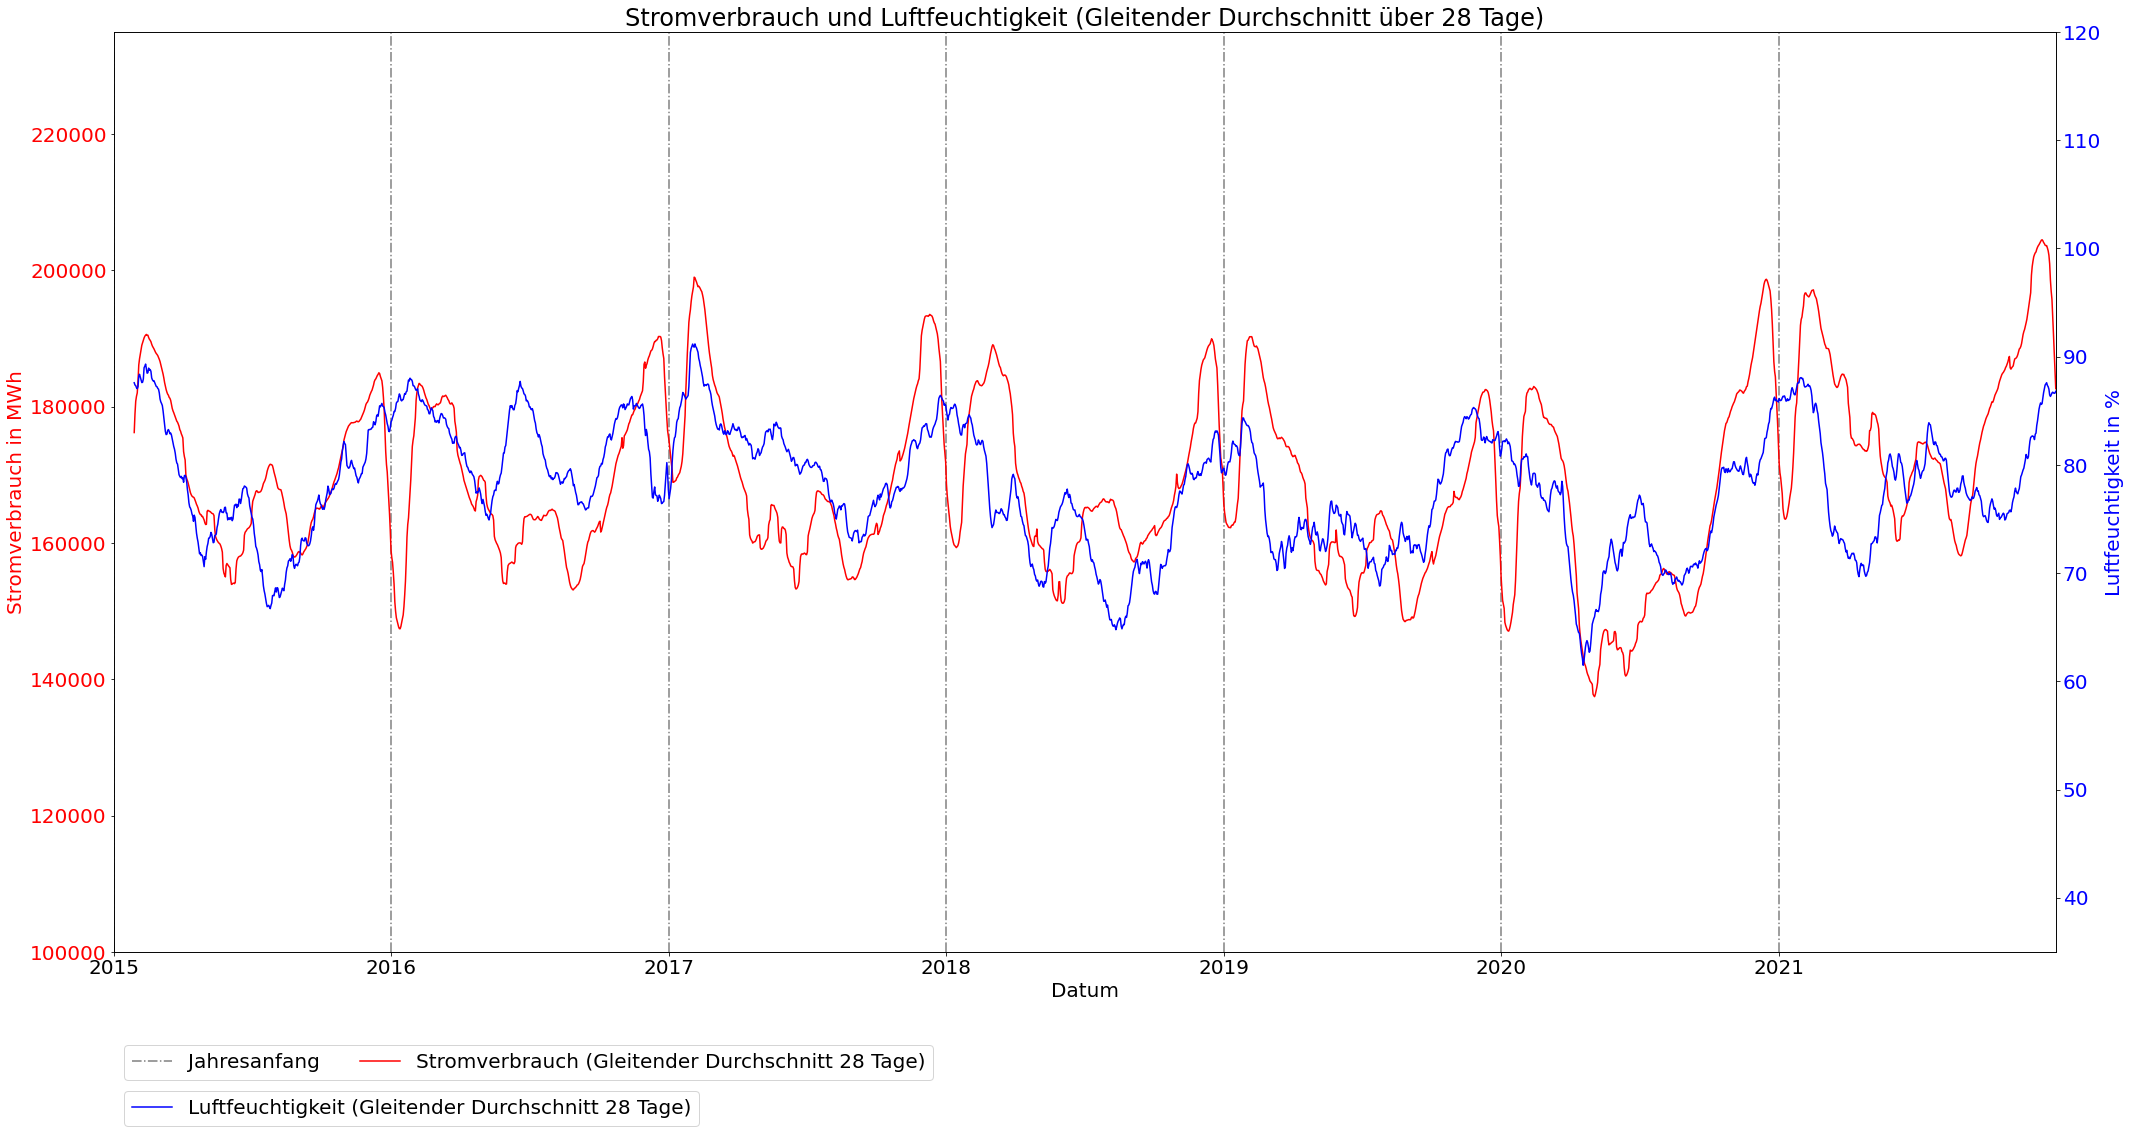

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.521
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.498
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.346





In [7]:
#Durchlaufen verschiedener gleitender Durchschnitte
for window in [3, 7, 14, 28]:

    print("\n\n", "Gleitender Durchschnitt über", window," Tage----------------------------------------------------------------------------------------------------------------------------------------------\n\n")
    
    fig, ax1 = plt.subplots()

    functions.draw_years(df)

    ax1.set_title("Stromverbrauch und Luftfeuchtigkeit (Gleitender Durchschnitt über " + str(window) + " Tage)")
    
    #Gleitenden Durchschnitt des Verbrauchs plotten
    ax1.plot(df["verbrauch"].rolling(window=window).mean(), color="red", label="Stromverbrauch (Gleitender Durchschnitt " + str(window) + " Tage)")
    #Achsen und Layout
    ax1.set_ylabel("Stromverbrauch in MWh", color="red")
    ax1.tick_params(axis="y", labelcolor="red")
    ax1.set_ylim(100000,235000)
    ax1.set_xlabel("Datum")
    ax1.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

    #Legende einfügen
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)
    
    #Gleitenden Durchschnitt der Temperatur plotten
    ax2 = ax1.twinx()
    ax2.plot(df["luftfeuchtigkeit"].rolling(window=window).mean(), color="blue", label="Luftfeuchtigkeit (Gleitender Durchschnitt " + str(window) + " Tage)")
    #Achsen und Layout
    ax2.set_ylabel("Luftfeuchtigkeit in %", color="blue")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.set_ylim(35, 120)
    ax2.set_xlabel("Datum")
    ax2.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

    #Legende einfügen
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

    plt.tight_layout()
    plt.show()

    #Korrelationskoeffizienten ausgeben
    functions.correlation_coefficients(df["luftfeuchtigkeit"].rolling(window=window).mean().dropna(), df["verbrauch"].rolling(window=window).mean().dropna())
    print("\n\n")

## <font size="6">Stromverbrauch nach Luftfeuchtigkeit (Scatterplot)</font>

<font size="5">Im Scatterplot ist der Stromverbrauch auf der y-Achse und die Luftfeuchtigkeit auf der x-Achse abgebildet. Die Tage sind nach Arbeitstagen (rot) und arbeitsfreien Tagen (blau) getrennt. Per Regression wird versucht, einen linearen Zusammenhang zwischen den beiden Merkmalen zu ermitteln. Es ist erkennbar, dass der Stromverbrauch mit steigender Luftfeuchtigkeit ebenfalls steigt. Es muss allerdings immer noch geprüft werden, ob dieser Zusammenhang kausal auf die Temperatur oder andere Ursachen zurückzuführen ist.</font>

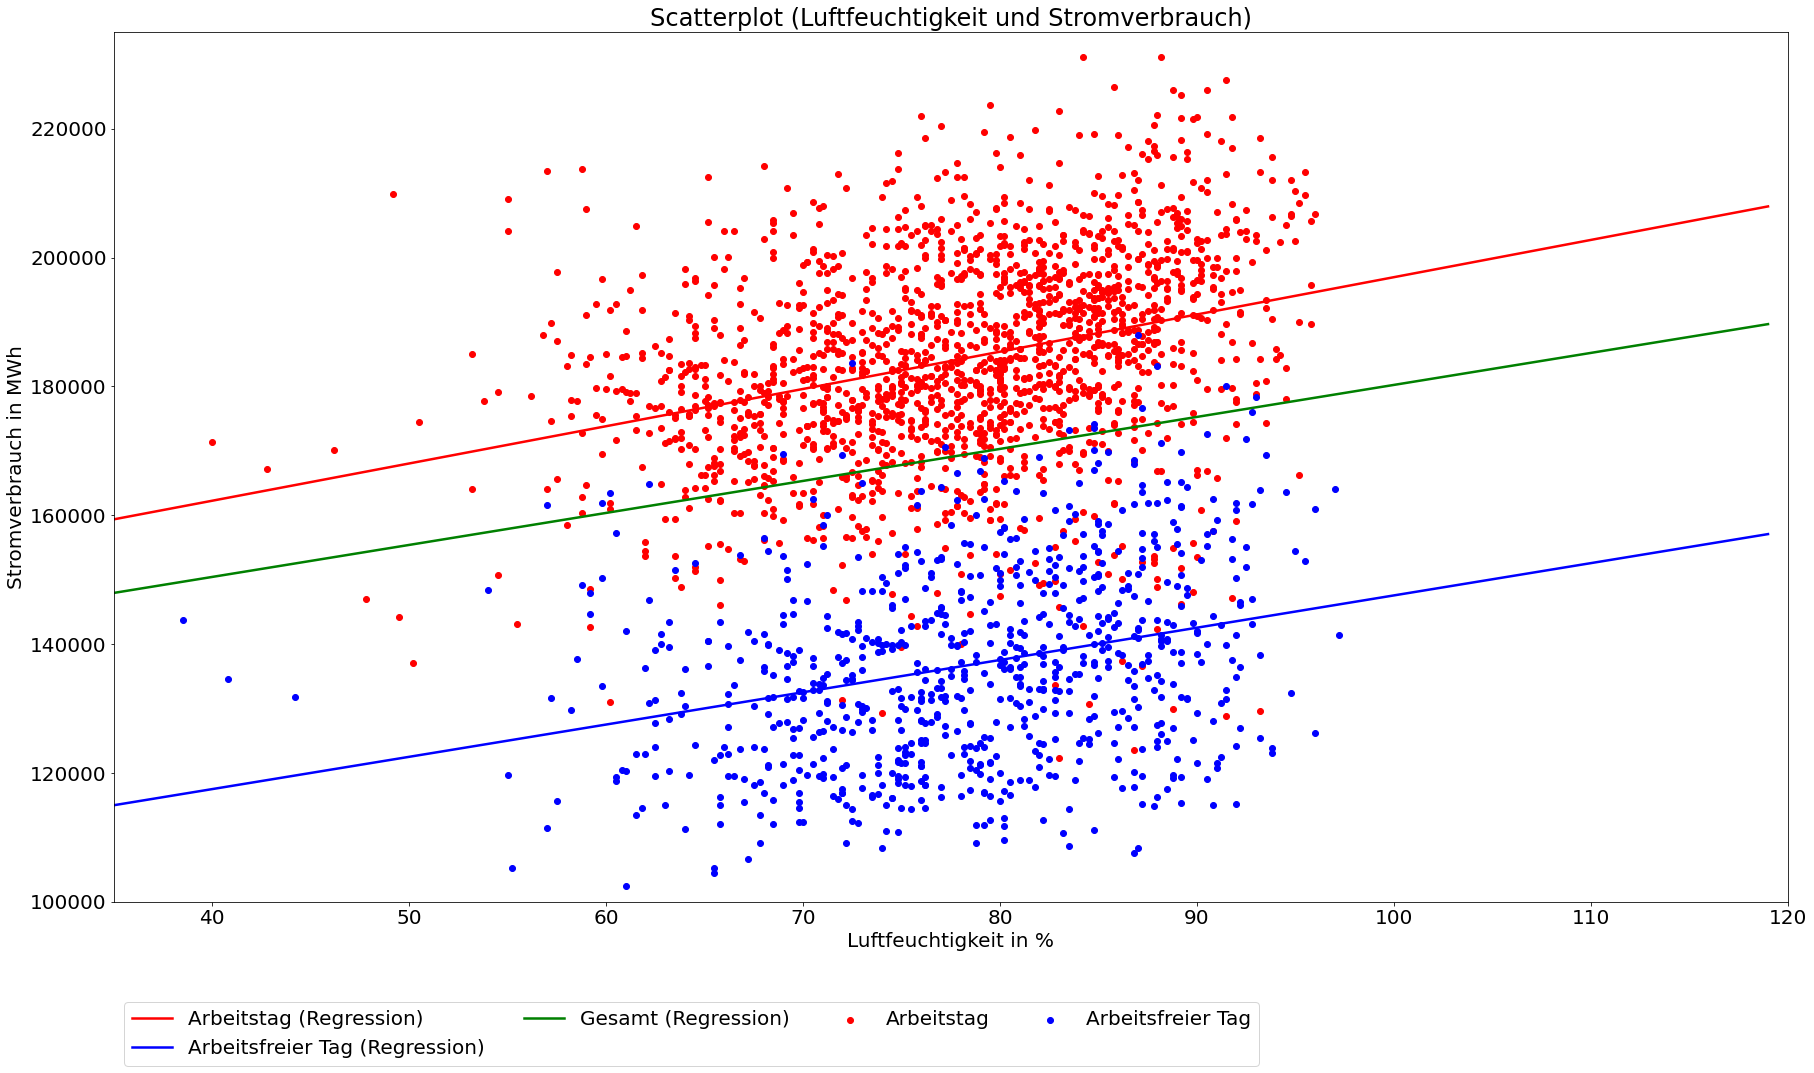

Arbeitstage
Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.316
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.355
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.244


Arbeitsfreie Tage
Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.285
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.297
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.203


In [8]:
x = range(35, 120, 1)

#Luftfeuchtigkeit und Verbrauch an Arbeitstagen plotten
plt.scatter(df_arbeitstag["luftfeuchtigkeit"], df_arbeitstag["verbrauch"], color="red", label="Arbeitstag")
#Steigung und Intercept für Regression bilden
m1, b1 = np.polyfit(df_arbeitstag["luftfeuchtigkeit"], df_arbeitstag["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m1 * x + b1, color="red", linewidth=2.5, label="Arbeitstag (Regression)")

#Luftfeuchtigkeit und Verbrauch an arbeitsfreien Tagen plotten
plt.scatter(df_arbeitsfreiertag["luftfeuchtigkeit"], df_arbeitsfreiertag["verbrauch"], color="blue", label="Arbeitsfreier Tag")
#Steigung und Intercept für Regression bilden
m2, b2 = np.polyfit(df_arbeitsfreiertag["luftfeuchtigkeit"], df_arbeitsfreiertag["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m2 * x + b2, color="blue", linewidth=2.5, label="Arbeitsfreier Tag (Regression)")

#Steigung und Intercept für Regression mit allen Tagen bilden
m3, b3 = np.polyfit(df["luftfeuchtigkeit"], df["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m3 * x + b3, color="green", linewidth=2.5, label="Gesamt (Regression)")

#Achsen und Layout
plt.title("Scatterplot (Luftfeuchtigkeit und Stromverbrauch)")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000, 235000)
plt.xlabel("Luftfeuchtigkeit in %")
plt.xlim(35, 120)

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.show()

#Korrelationskoeffizienten ausgeben
print("Arbeitstage")
functions.correlation_coefficients(df_arbeitstag["luftfeuchtigkeit"], df_arbeitstag["verbrauch"])
print("\n\nArbeitsfreie Tage")
functions.correlation_coefficients(df_arbeitsfreiertag["luftfeuchtigkeit"], df_arbeitsfreiertag["verbrauch"])

## <font size="6">Stromverbrauch nach Luftfeuchtigkeit (Boxplot)</font><a class="anchor" id="2-04b-boxplots"></a>

<font size="5">Der gemeinsame Verlauf von Stromverbrauch und Luftfeuchtigkeit und der vermeintliche Zusammenhang zeigt sich auch bei den Boxplots.</font>

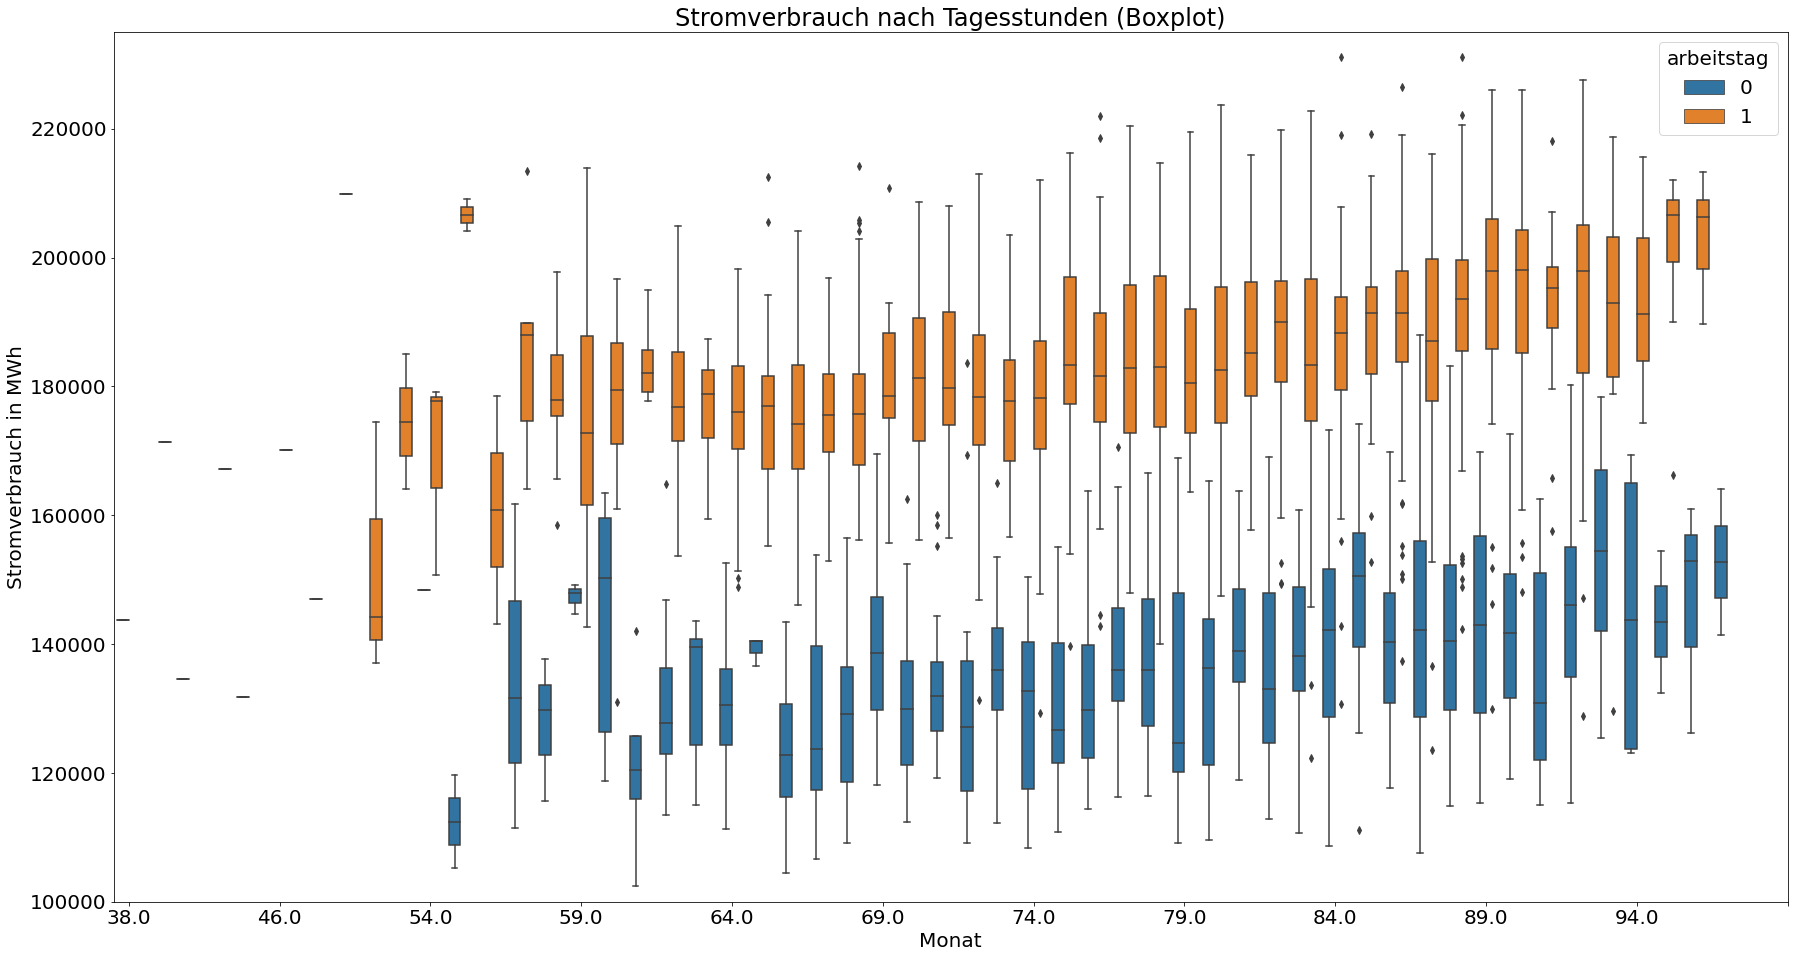

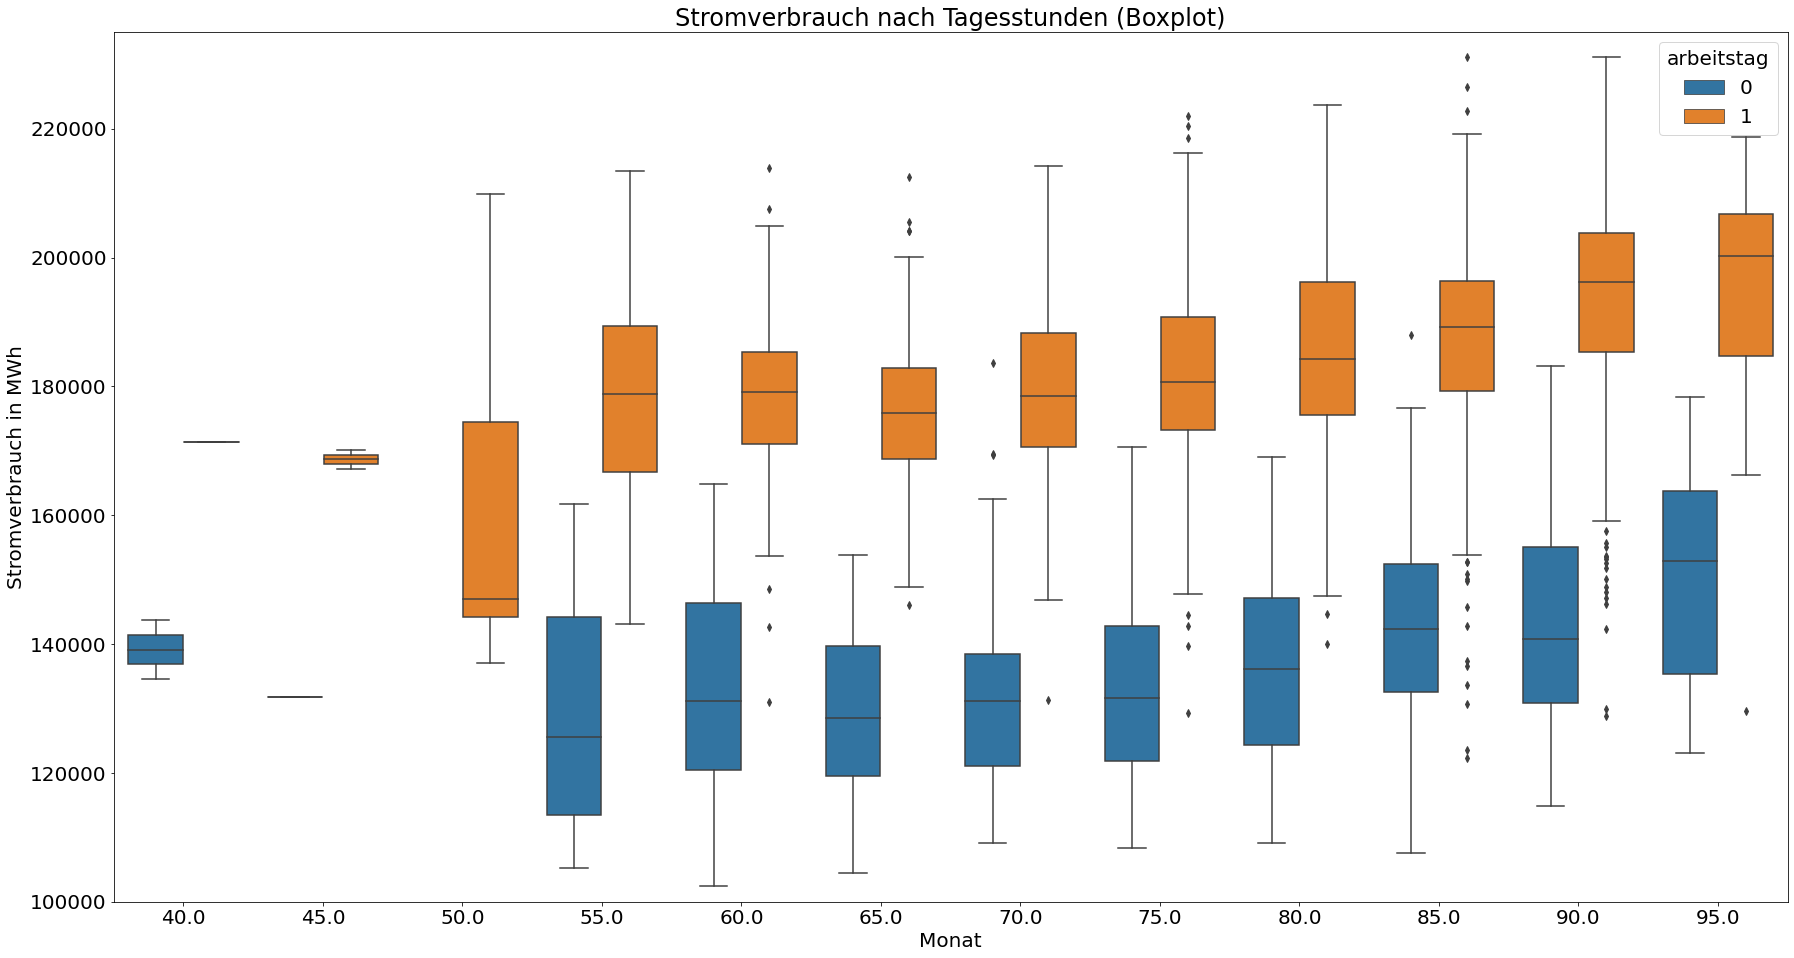

In [9]:
#Boxplot der gerundeten Luftfeuchtigkeit
sns.boxplot(data=df, x="luftfeuchtigkeit_gerundet", y="verbrauch", hue="arbeitstag")

#Achsen und Layout
plt.title("Stromverbrauch nach Tagesstunden (Boxplot)")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Monat")
plt.xticks(np.arange(0, 60, 5))

plt.show()

#Boxplot der gruppierten Luftfeuchtigkeit
sns.boxplot(data=df, x="luftfeuchtigkeit_gruppiert", y="verbrauch", hue="arbeitstag")

#Achsen und Layout
plt.title("Stromverbrauch nach Tagesstunden (Boxplot)")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Monat")

plt.show()

## <font size="6">Luftfeuchtigkeit und Temperatur</font><a class="anchor" id="2-04b-luftfeuchtigkeitundtemperatur"></a>

<font size="5">Da die relative Luftfeuchtigkeit unter anderem stark von der Temperatur abhängig ist, muss geprüft werden, ob es sich beim Stromverbrauch um eine tatsächliche Korrelation oder nur um eine Scheinkorrelation mit der Temperatur handelt. Die untere Grafik zeigt den oben beschriebenen Zusammenhang der Temperatur und der Luftfeuchtigkeit: Höhere Temperaturen gehen oft mit einer niedrigeren Luftfeuchtigkeit einher.<font size="5">

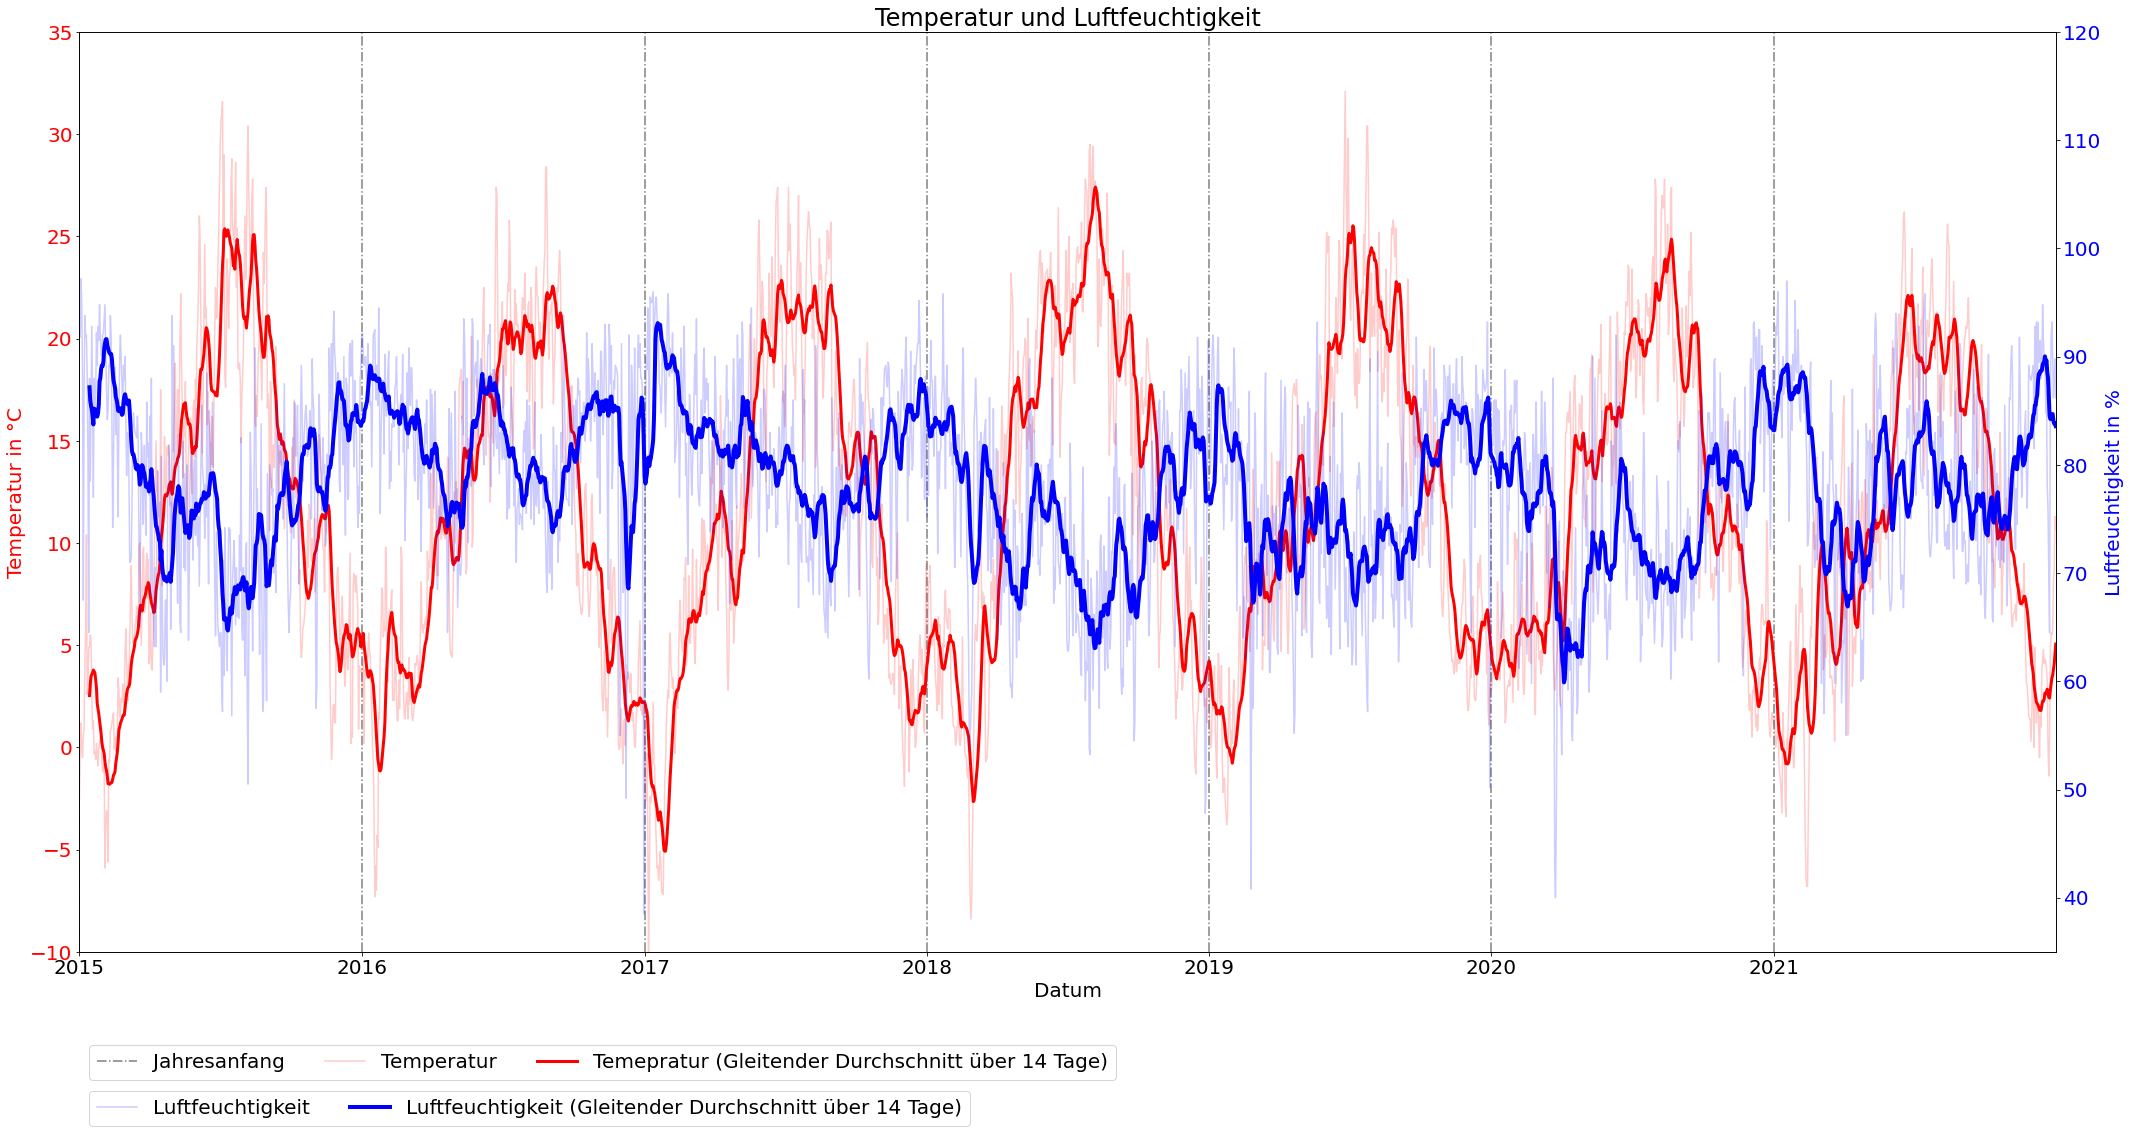

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.452
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.486
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.342


Für gleitenden Durchschnitt über 14 Tage
Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.598
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.607
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von -0.439





In [10]:
fig, ax1 = plt.subplots()

functions.draw_years(df)

ax1.set_title("Temperatur und Luftfeuchtigkeit")

#Temperatur plotten
ax1.plot(df["temperatur"], color="red", alpha=0.2, label="Temperatur")
ax1.plot(df["temperatur"].rolling(window=14).mean(), color="red", linewidth=3, label="Temepratur (Gleitender Durchschnitt über 14 Tage)")
#Achsen und Layout
ax1.set_ylabel("Temperatur in °C", color="red")
ax1.tick_params(axis="y", labelcolor="red")
ax1.set_ylim(-10, 35)
ax1.set_xlabel("Datum")
ax1.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)

ax2 = ax1.twinx()
#Luftfeuchtigkeit plotten
ax2.plot(df["luftfeuchtigkeit"], color="blue", alpha=0.2, label="Luftfeuchtigkeit")
ax2.plot(df["luftfeuchtigkeit"].rolling(window=14).mean(), color="blue", linewidth=4, label="Luftfeuchtigkeit (Gleitender Durchschnitt über 14 Tage)")
#Achsen und Layout
ax2.set_ylabel("Luftfeuchtigkeit in %", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.set_ylim(35, 120)
ax2.set_xlabel("Datum")
ax2.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.tight_layout()
plt.show()

#Korrelationskoeffizienten ausgeben
functions.correlation_coefficients(df["luftfeuchtigkeit"], df["temperatur"])
print("\n\nFür gleitenden Durchschnitt über 14 Tage")
functions.correlation_coefficients(df["luftfeuchtigkeit"].rolling(window=14).mean().dropna(), df["temperatur"].rolling(window=14).mean().dropna())
print("\n\n")

## <font size="6">Stromverbrauch nach Luftfeuchtigkeit und Temperatur (Scatterplot)</font><a class="anchor" id="2-04b-scatterplot2"></a>

<font size="5">Im Scatterplot ist der Stromverbrauch auf der y-Achse und die Luftfeuchtigkeit auf der x-Achse abgebildet. Wie auch bei der Analyse der Tagesstunden repräsentieren gelbe Punkte Tage mit hohen, grüne Punkte mit mittlerem und blaue/lilane Punkte Tage mit niedrigem Stromverbrauch. Anders als bei den Tagesstunden und der Temperatur lässt sich im Scatterplot der Luftfeuchtigkeit und der Temperatur kein zusätzlicher Informationsgewinn aus der Luftfeuchtigkeit ablesen. Die Werte auf der x-Achse lassen sich nicht an der y-Achse durch den Stromverbrauch unterscheiden. Es handelt sich daher sehr wahrscheinlich um eine Scheinkorrelation des Stromverbrauchs und der Luftfeuchtigkeit. Bei steigenden Temperaturen fällt der Stromverbrauch (bis zu einem gewissen Grad), gleichzeitig fällt allerdings auch die relative Luftfeuchtigkeit. Durch die Korrelation von Temperatur und Stromverbrauch sowie die Korrelation von Temperatur und Luftfeuchtigkeit ergibt sich eine Scheinkorrelation.<font size="5">

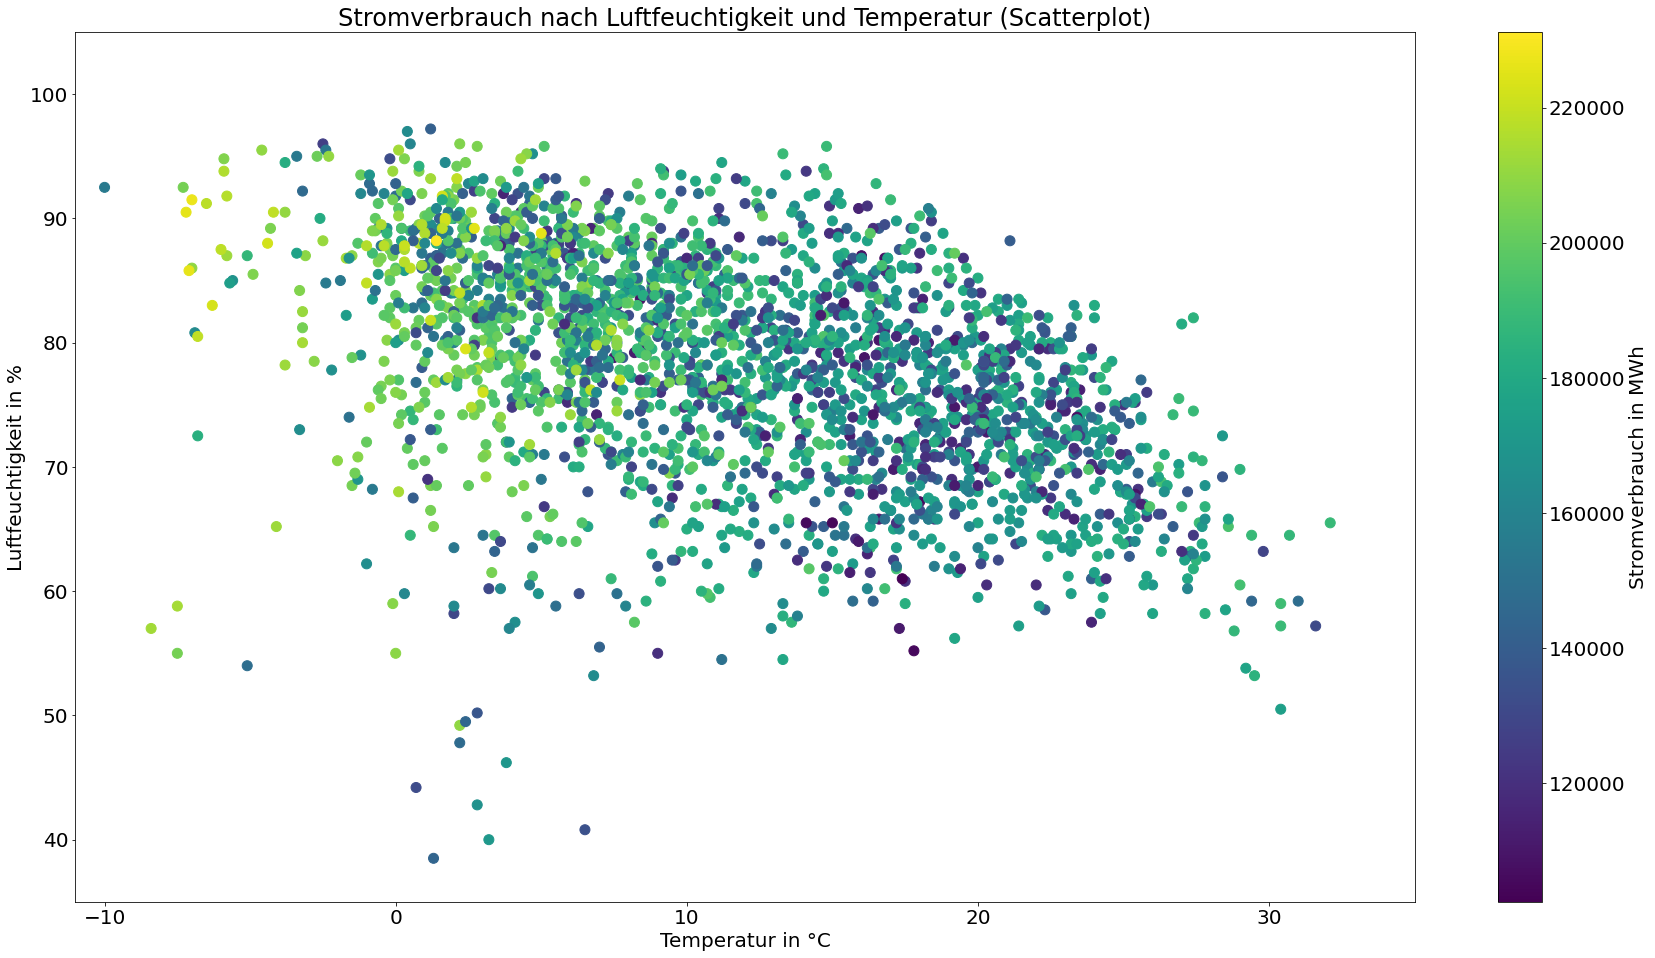

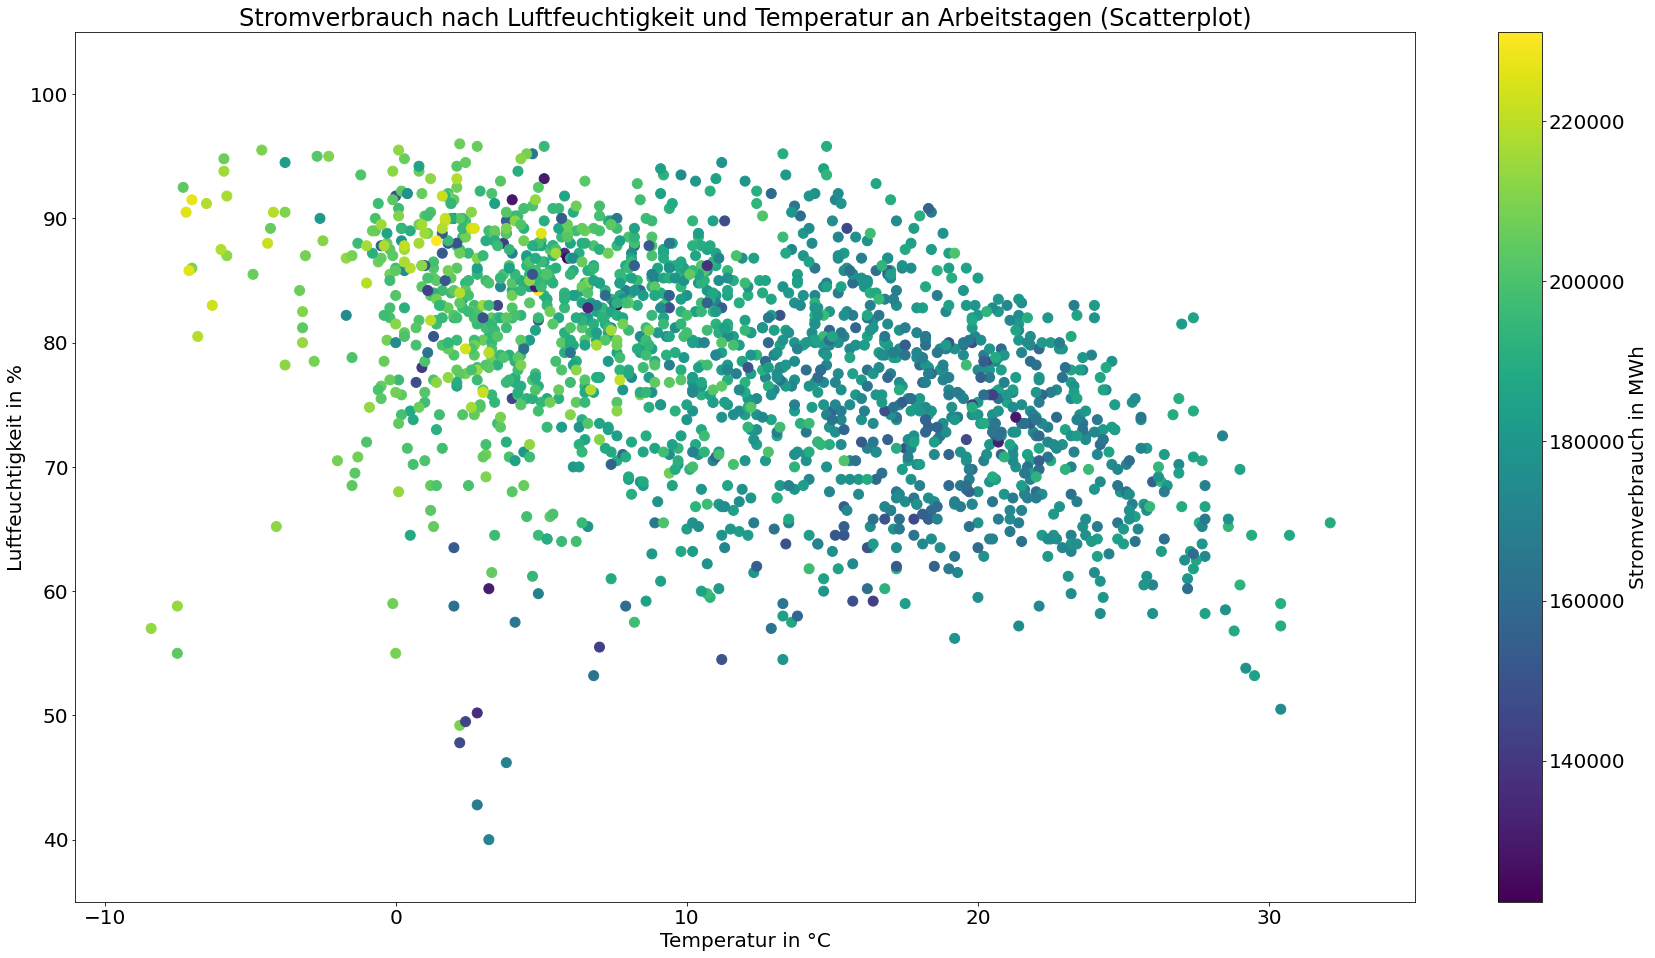

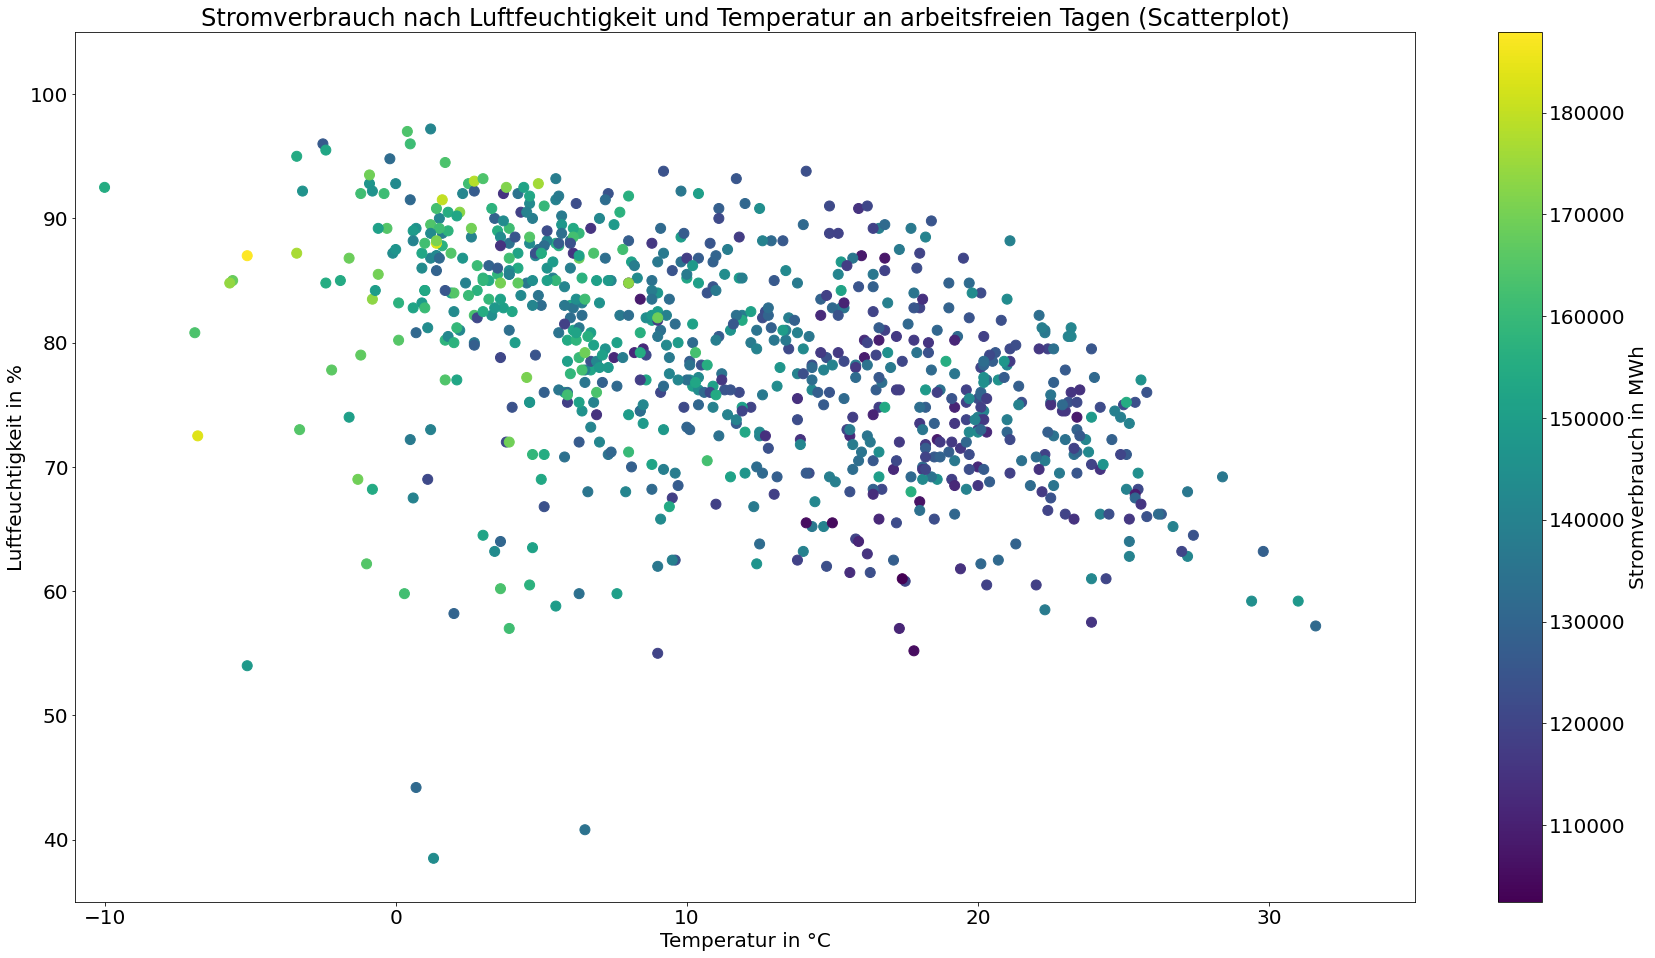

In [11]:
fig, ax = plt.subplots()

#Scatterplot mit Temperatur, Luftfeuchtigkeit und Verbrauch an allen Tagen
scat = ax.scatter(df["temperatur"], df["luftfeuchtigkeit"], c=df["verbrauch"], s=100, marker='o')
#Achsen und Layout
ax.set_title("Stromverbrauch nach Luftfeuchtigkeit und Temperatur (Scatterplot)")
ax.set_ylabel("Luftfeuchtigkeit in %")
ax.set_ylim(35, 105)
ax.set_xlabel("Temperatur in °C")
ax.set_xlim(-11, 35)
fig.colorbar(scat, label="Stromverbrauch in MWh")

plt.show()

fig, ax = plt.subplots()

#Scatterplot mit Temperatur, Luftfeuchtigkeit und Verbrauch an Arbeitstagen
scat = ax.scatter(df_arbeitstag["temperatur"], df_arbeitstag["luftfeuchtigkeit"], c=df_arbeitstag["verbrauch"], s=100, marker='o')
#Achsen und Layout
ax.set_title("Stromverbrauch nach Luftfeuchtigkeit und Temperatur an Arbeitstagen (Scatterplot)")
ax.set_ylabel("Luftfeuchtigkeit in %")
ax.set_ylim(35, 105)
ax.set_xlabel("Temperatur in °C")
ax.set_xlim(-11, 35)
fig.colorbar(scat, label="Stromverbrauch in MWh")

plt.show()

fig, ax = plt.subplots()

#Scatterplot mit Temperatur, Luftfeuchtigkeit und Verbrauch an arbeitsfreien Tagen
scat = ax.scatter(df_arbeitsfreiertag["temperatur"], df_arbeitsfreiertag["luftfeuchtigkeit"], c=df_arbeitsfreiertag["verbrauch"], s=100, marker='o')
#Achsen und Layout
ax.set_title("Stromverbrauch nach Luftfeuchtigkeit und Temperatur an arbeitsfreien Tagen (Scatterplot)")
ax.set_ylabel("Luftfeuchtigkeit in %")
ax.set_ylim(35, 105)
ax.set_xlabel("Temperatur in °C")
ax.set_xlim(-11, 35)
fig.colorbar(scat, label="Stromverbrauch in MWh")

plt.show()

# <font size="7">Regressionsanalyse</font>

<font size="5">Durch die Regressionsanalyse wird geprüft, inwieweit sich der Verlauf des Stromverbrauchs anhand der verfügbaren exogenen Merkmale modellieren lässt. Es geht dabei noch nicht um die Erstellung eines Vorhersagemodells. Stattdessen wird die Regressionsanalyse eher mit Blick auf potenzielle Zusammenhänge, Korrelationen und Muster beziehungsweise generelle Verläufe durchgeführt. Aus diesem Grund bietet sich eine Funktion sechsten Grades an. Dafür wird mit den Daten von 2015 bis 2018 und den entsprechenden Merkmalen eine Regression sechsten Grades durchgeführt, welche dann mit den Daten für 2019 getestet wird. Wie bereits erwähnt, gibt es 2020 und 2021 Abweichungen vom ansonsten üblichen Verlauf. Daher werden nur die Daten bis einschließlich 2019 verwendet.</font>

## <font size="6">Regression mit Luftfeuchtigkeit</font>

<font size="5">Mittels einer Regression auf die Luftfeuchtigkeit kann die jährliche Saisonalität nicht abgebildet werden. Das Regressionsmodell kann keine Informationen aus den Daten ziehen, um den Stromverbrauch zu abzubilden. Es kann also nicht einmal die Scheinkorrelation erfasst werden.</font>

            verbrauch  luftfeuchtigkeit
datum                                  
2015-01-01   126197.0              96.0
2015-01-02   147085.0              91.8
2015-01-03   141426.0              97.2
2015-01-04   132446.0              94.8
2015-01-05   152611.0              87.8
...               ...               ...
2019-12-27   129551.0              93.2
2019-12-28   125395.0              84.2
2019-12-29   121331.0              69.0
2019-12-30   137130.0              50.2
2019-12-31   131060.0              60.2

[1826 rows x 2 columns]
       Vorhersage
R2           -0.0
MAE       21743.5
MSE   704094709.2
RMSE      26534.8
                 
MAPE       14.6 %


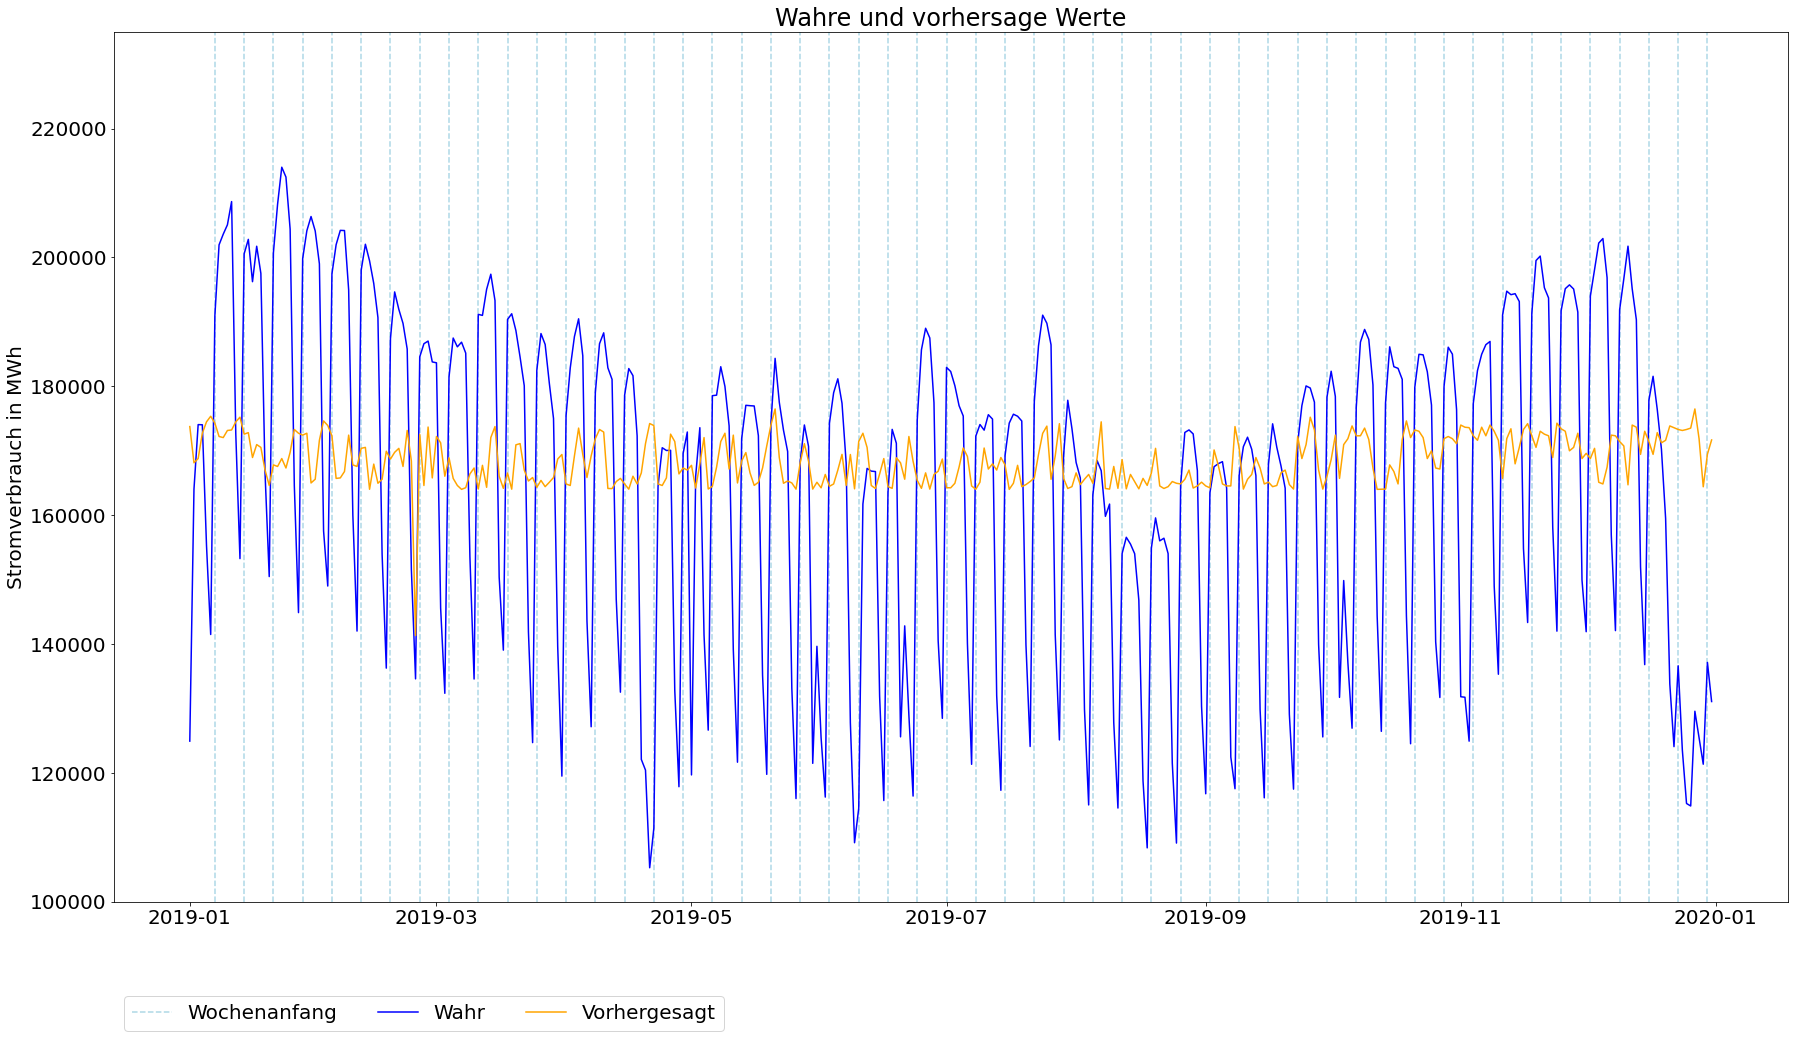

In [12]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["luftfeuchtigkeit"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["luftfeuchtigkeit"]].values.reshape(-1, 1))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["luftfeuchtigkeit"]])
X_test = pf.transform(test[["luftfeuchtigkeit"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

## <font size="6">Regression mit Arbeitstag und Luftfeuchtigkeit</font>

<font size="5">Wird der Indikator für Arbeitstage hinzugezogen, verbessert sich das Modell, allerdings ist diese Verbesserung vollständig auf den Indikator zurückzuführen. Ohne die Temperatur erreicht man mit den Arbeitstagindikator bereits einen MAPE von 7 bis 8%, der durch die Luftfeuchtigkeit nicht verbessert werden kann.</font>

            verbrauch  arbeitstag  luftfeuchtigkeit
datum                                              
2015-01-01   126197.0         0.0              96.0
2015-01-02   147085.0         1.0              91.8
2015-01-03   141426.0         0.0              97.2
2015-01-04   132446.0         0.0              94.8
2015-01-05   152611.0         1.0              87.8
...               ...         ...               ...
2019-12-27   129551.0         1.0              93.2
2019-12-28   125395.0         0.0              84.2
2019-12-29   121331.0         0.0              69.0
2019-12-30   137130.0         1.0              50.2
2019-12-31   131060.0         1.0              60.2

[1826 rows x 3 columns]
       Vorhersage
R2            0.7
MAE       11172.7
MSE   213597948.3
RMSE      14615.0
                 
MAPE        7.2 %


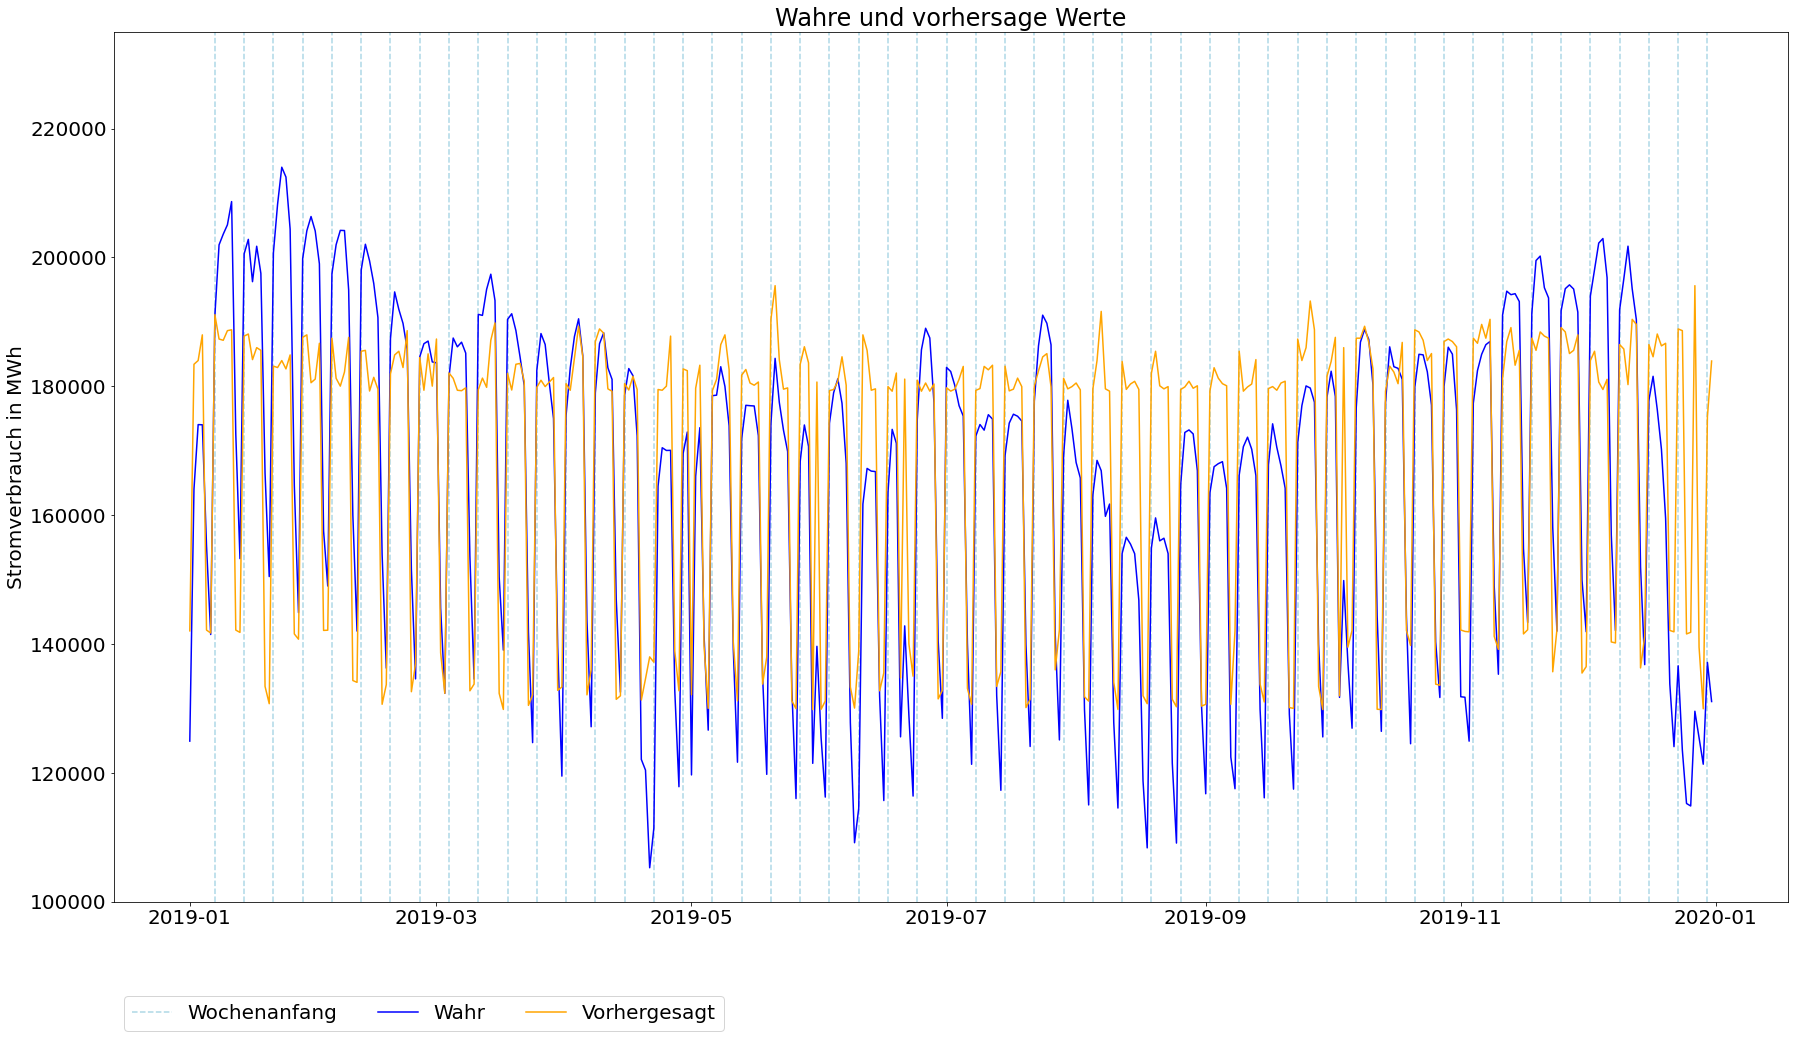

In [13]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["arbeitstag"], df["luftfeuchtigkeit"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["arbeitstag", "luftfeuchtigkeit"]].values.reshape(-2, 2))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["arbeitstag", "luftfeuchtigkeit"]])
X_test = pf.transform(test[["arbeitstag", "luftfeuchtigkeit"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

## <font size="6">Regression mit Arbeitstagen, Temperatur, Tagesstunden und Luftfeuchtigkeit</font><a class="anchor" id="2-04b-regressionalles"></a>

<font size="5">Wird die Luftfeuchtigkeit zu den bisher als aussagekräftig ermittelten Merkmalen (Arbeitstag, Temperatur, Tagesstunden) hinzugefügt, dann verschlechtert sich das Modell erheblich im Vergleich zur Regression ohne die Luftfeuchtigkeit. Das Merkmal bietet also keine zusätzlichen Informationen und wird daher nicht für die Modellierung verwendet.</font>

            verbrauch  tagesstunden  arbeitstag  temperatur  luftfeuchtigkeit
datum                                                                        
2015-01-01   126197.0           8.4         0.0        -2.5              96.0
2015-01-02   147085.0           8.4         1.0        -0.0              91.8
2015-01-03   141426.0           8.4         0.0         1.2              97.2
2015-01-04   132446.0           8.4         0.0        -0.2              94.8
2015-01-05   152611.0           8.4         1.0        -0.5              87.8
...               ...           ...         ...         ...               ...
2019-12-27   129551.0           8.3         1.0         5.1              93.2
2019-12-28   125395.0           8.3         0.0         1.7              84.2
2019-12-29   121331.0           8.3         0.0         1.1              69.0
2019-12-30   137130.0           8.3         1.0         2.8              50.2
2019-12-31   131060.0           8.3         1.0         3.2     

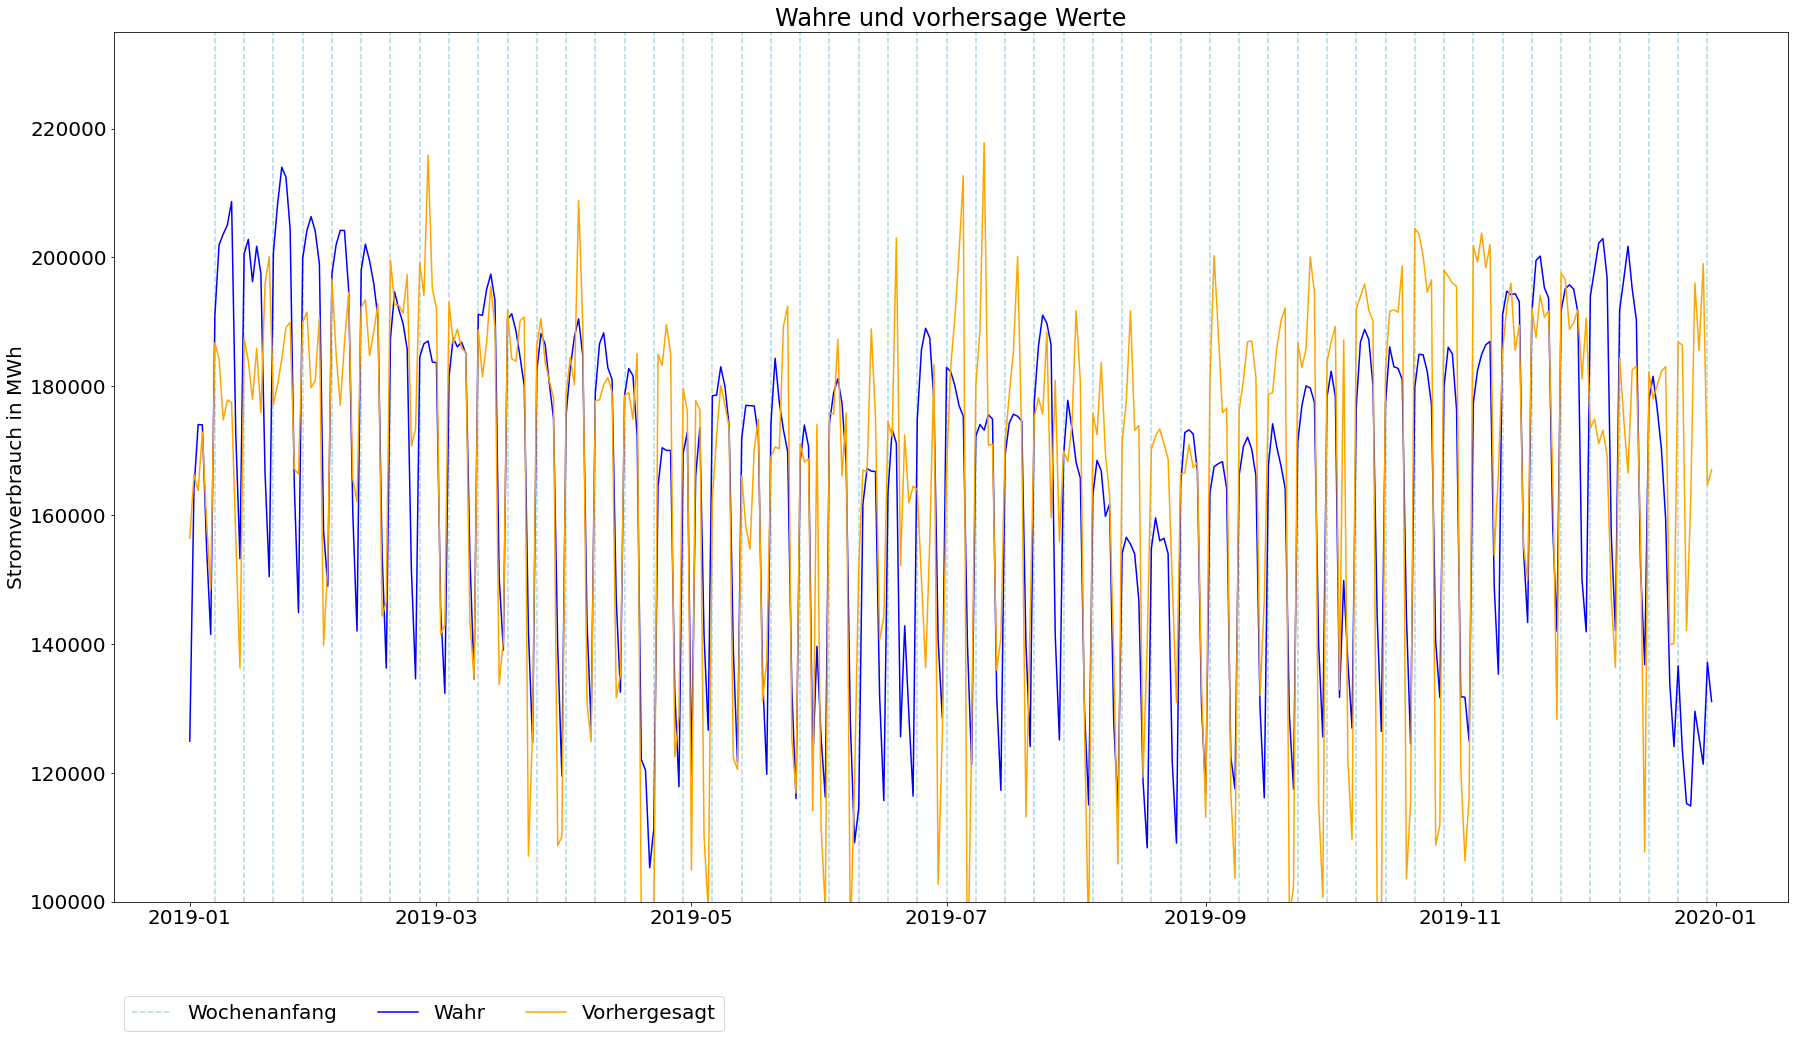

In [14]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["tagesstunden"], df["arbeitstag"], df["temperatur"], df["luftfeuchtigkeit"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=4)
pf = pf.fit(df_regression[["tagesstunden", "arbeitstag", "temperatur", "luftfeuchtigkeit"]].values.reshape(-4, 4))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["tagesstunden", "arbeitstag", "temperatur", "luftfeuchtigkeit"]])
X_test = pf.transform(test[["tagesstunden", "arbeitstag", "temperatur", "luftfeuchtigkeit"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

# <font size="7">Fazit</font>
<font size="5">Beim zunächst scheinbaren Zusammenhang von Luftfeuchtigkeit und Stromverbrauch handelt es sich um eine Scheinkorrelation, die Kausalität liegt in beiden Fällen in der Temperatur begründet. Aus diesem Grund wird die Luftfeuchtigkeit nicht für die Modellierung verwendet.</font>